# 0 Introduction to the project

The main goal was to build a novel method for Test Time Adaptation (TTA). With TTA we refer to techninques that aims to improve the network performance one sample at a time. We choose to develop our TTA algorithm on top of [TPT](https://arxiv.org/pdf/2209.07511) (Test-time Prompt Tuning).

As TPT, the network used for this project is [CLIP](https://arxiv.org/pdf/2103.00020) (Contrastive Learining Image Pre-training) with [CoOp](https://arxiv.org/pdf/2109.01134) (Context Optimization) that is used for improving the performances of models like CLIP (vision language), keeping all the parameters fixed and optimizing the prompt.

Our work focuses on the two part that we think are crucial for TPT:
1.   Sample selection: we developed a method that select the samples in an adaptive way based on the batch entropy,
2. Augmentation of images: for it we propose a method for getting better augmentation using the attention taken from [DINO](https://arxiv.org/pdf/2104.14294) in order to have a guess on which part of the image contains the information.


The notebook is characterized by three principal parts:
- The first one is about installing all the dependencies and introducing TPT.

- The second part contains our two methods for performing Test Time Adaptation.

- The last part shows some results of our work and a comparison both with the original work developed (TPT) and among the improvements obtained with the different methods implemented.

-----

This project was runned on Colab and it was developed by Davide De Martini, Mattia Rigon and Marina Segala.

# 1 Setup the notebook

## 1.1 Download all the dependencies

In [ ]:
!pip install numpy
!pip install git+https://github.com/openai/CLIP.git
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install pillow
!pip install scikit-image
!pip install ipykernel
!pip install ftfy
!pip install opencv-python
!pip install gdown
!sudo apt-get install libgl1-mesa-glx -y

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-pffps2i1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-pffps2i1
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 549.7 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

## 1.2 Download and unzip the dataset ([imagenet-a](https://arxiv.org/pdf/1907.07174v4))

In [ ]:
!gdown https://drive.google.com/uc?id=14UraOwNC19fXkrv0vW3JsdNLmZT3X6aB

Downloading...
From (original): https://drive.google.com/uc?id=14UraOwNC19fXkrv0vW3JsdNLmZT3X6aB
From (redirected): https://drive.google.com/uc?id=14UraOwNC19fXkrv0vW3JsdNLmZT3X6aB&confirm=t&uuid=8a9347d5-90f9-40bb-ad14-6a7ec5680ef2
To: /content/imagenet-a.zip
100% 681M/681M [00:38<00:00, 17.6MB/s]


In [ ]:
!unzip imagenet-a.zip

Streaming output truncated to the last 5000 lines.
  inflating: imagenet-a/n02051845/0.002708_balloon _ balloon_0.4267749.jpg  
  inflating: imagenet-a/n02051845/0.004384_submarine _ submarine_0.836834.jpg  
  inflating: imagenet-a/n02051845/0.004392_American alligator _ American alligator_0.80851156.jpg  
  inflating: imagenet-a/n02051845/0.004860_stingray _ stingray_0.9526049.jpg  
  inflating: imagenet-a/n02051845/0.005432_unicycle _ bald eagle_0.47000995.jpg  
  inflating: imagenet-a/n02051845/0.005645_box turtle _ volcano_0.7011412.jpg  
  inflating: imagenet-a/n02051845/0.005842_shipwreck _ shipwreck_0.6104582.jpg  
  inflating: imagenet-a/n02051845/0.005908_flagpole _ flagpole_0.46078628.jpg  
  inflating: imagenet-a/n02051845/0.006625_reel _ reel_0.96441346.jpg  
  inflating: imagenet-a/n02051845/0.006895_sulphur-crested cockatoo _ bald eagle_0.8069748.jpg  
  inflating: imagenet-a/n02051845/0.007672_toaster _ digital clock_0.75175005.jpg  
  inflating: imagenet-a/n02051845/0.0

## 1.3 Download the CoOp weights

In [ ]:
!gdown "https://drive.google.com/uc?id=1PL5l_ys7QGXGVYbebbMPffn8XN4xljxg"

Downloading...
From (original): https://drive.google.com/uc?id=1PL5l_ys7QGXGVYbebbMPffn8XN4xljxg
From (redirected): https://drive.google.com/uc?id=1PL5l_ys7QGXGVYbebbMPffn8XN4xljxg&confirm=t&uuid=66f98e07-d653-4c89-ad95-7e7b55f39964
To: /content/model.pth.tar-50
100% 74.8M/74.8M [00:04<00:00, 15.1MB/s]


## 1.4 Remove unnecessary files

In [ ]:
!rm imagenet-a.zip

## 1.5 Import the libraries

In [ ]:
from copy import deepcopy

from PIL import Image

import time
import random
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from torchvision.transforms import InterpolationMode
from torchvision import datasets

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


# 2 Common variables

## 2.1 Flags and global variables

Here there are all the global variable used by our project

In [ ]:
# Common flags for tpt
BICUBIC = InterpolationMode.BICUBIC
SEED = 0
GPU = 0
N_CTX = 4
CTX_INIT = ""
WEIGHTS = "./model.pth.tar-50"
ARCH = "RN50"
LR = 5e-3
RESOLUTION = 224
SET = "A"
VIEWS = 63
DATA = "./imagenet-a"
TTA_STEPS = 1
SELECTION_P = 0.1

# Set up the minumum threshold for selection in our method
TRESHOLD = 6

OUR_SELECTION = False #initially is false for seeing the basic TPT
VISUALIZE_PLOT = False # visualize the plots for the derivatives
DINO = False

MEAN = [0.48145466, 0.4578275, 0.40821073]
STD = [0.26862954, 0.26130258, 0.27577711]

## 2.2 Imagenet classes

The original Imagenet has 1000 classes, the dataset used in this project (imagenet-a) has only 200 out of the 1000 classes. For this reason, we have to craft a mask to map the 1000 classes onto the 200.

In [ ]:
imagenet_classes = ["tench", "goldfish", "great white shark", "tiger shark", "hammerhead shark", "electric ray", "stingray", "rooster", "hen", "ostrich", "brambling", "goldfinch", "house finch", "junco", "indigo bunting", "American robin", "bulbul", "jay", "magpie", "chickadee", "American dipper", "kite (bird of prey)", "bald eagle", "vulture", "great grey owl", "fire salamander", "smooth newt", "newt", "spotted salamander", "axolotl", "American bullfrog", "tree frog", "tailed frog", "loggerhead sea turtle", "leatherback sea turtle", "mud turtle", "terrapin", "box turtle", "banded gecko", "green iguana", "Carolina anole", "desert grassland whiptail lizard", "agama", "frilled-necked lizard", "alligator lizard", "Gila monster", "European green lizard", "chameleon", "Komodo dragon", "Nile crocodile", "American alligator", "triceratops", "worm snake", "ring-necked snake", "eastern hog-nosed snake", "smooth green snake", "kingsnake", "garter snake", "water snake", "vine snake", "night snake", "boa constrictor", "African rock python", "Indian cobra", "green mamba", "sea snake", "Saharan horned viper", "eastern diamondback rattlesnake", "sidewinder rattlesnake", "trilobite", "harvestman", "scorpion", "yellow garden spider", "barn spider", "European garden spider", "southern black widow", "tarantula", "wolf spider", "tick", "centipede", "black grouse", "ptarmigan", "ruffed grouse", "prairie grouse", "peafowl", "quail", "partridge", "african grey parrot", "macaw", "sulphur-crested cockatoo", "lorikeet", "coucal", "bee eater", "hornbill", "hummingbird", "jacamar", "toucan", "duck", "red-breasted merganser", "goose", "black swan", "tusker", "echidna", "platypus", "wallaby", "koala", "wombat", "jellyfish", "sea anemone", "brain coral", "flatworm", "nematode", "conch", "snail", "slug", "sea slug", "chiton", "chambered nautilus", "Dungeness crab", "rock crab", "fiddler crab", "red king crab", "American lobster", "spiny lobster", "crayfish", "hermit crab", "isopod", "white stork", "black stork", "spoonbill", "flamingo", "little blue heron", "great egret", "bittern bird", "crane bird", "limpkin", "common gallinule", "American coot", "bustard", "ruddy turnstone", "dunlin", "common redshank", "dowitcher", "oystercatcher", "pelican", "king penguin", "albatross", "grey whale", "killer whale", "dugong", "sea lion", "Chihuahua", "Japanese Chin", "Maltese", "Pekingese", "Shih Tzu", "King Charles Spaniel", "Papillon", "toy terrier", "Rhodesian Ridgeback", "Afghan Hound", "Basset Hound", "Beagle", "Bloodhound", "Bluetick Coonhound", "Black and Tan Coonhound", "Treeing Walker Coonhound", "English foxhound", "Redbone Coonhound", "borzoi", "Irish Wolfhound", "Italian Greyhound", "Whippet", "Ibizan Hound", "Norwegian Elkhound", "Otterhound", "Saluki", "Scottish Deerhound", "Weimaraner", "Staffordshire Bull Terrier", "American Staffordshire Terrier", "Bedlington Terrier", "Border Terrier", "Kerry Blue Terrier", "Irish Terrier", "Norfolk Terrier", "Norwich Terrier", "Yorkshire Terrier", "Wire Fox Terrier", "Lakeland Terrier", "Sealyham Terrier", "Airedale Terrier", "Cairn Terrier", "Australian Terrier", "Dandie Dinmont Terrier", "Boston Terrier", "Miniature Schnauzer", "Giant Schnauzer", "Standard Schnauzer", "Scottish Terrier", "Tibetan Terrier", "Australian Silky Terrier", "Soft-coated Wheaten Terrier", "West Highland White Terrier", "Lhasa Apso", "Flat-Coated Retriever", "Curly-coated Retriever", "Golden Retriever", "Labrador Retriever", "Chesapeake Bay Retriever", "German Shorthaired Pointer", "Vizsla", "English Setter", "Irish Setter", "Gordon Setter", "Brittany dog", "Clumber Spaniel", "English Springer Spaniel", "Welsh Springer Spaniel", "Cocker Spaniel", "Sussex Spaniel", "Irish Water Spaniel", "Kuvasz", "Schipperke", "Groenendael dog", "Malinois", "Briard", "Australian Kelpie", "Komondor", "Old English Sheepdog", "Shetland Sheepdog", "collie", "Border Collie", "Bouvier des Flandres dog", "Rottweiler", "German Shepherd Dog", "Dobermann", "Miniature Pinscher", "Greater Swiss Mountain Dog", "Bernese Mountain Dog", "Appenzeller Sennenhund", "Entlebucher Sennenhund", "Boxer", "Bullmastiff", "Tibetan Mastiff", "French Bulldog", "Great Dane", "St. Bernard", "husky", "Alaskan Malamute", "Siberian Husky", "Dalmatian", "Affenpinscher", "Basenji", "pug", "Leonberger", "Newfoundland dog", "Great Pyrenees dog", "Samoyed", "Pomeranian", "Chow Chow", "Keeshond", "brussels griffon", "Pembroke Welsh Corgi", "Cardigan Welsh Corgi", "Toy Poodle", "Miniature Poodle", "Standard Poodle", "Mexican hairless dog (xoloitzcuintli)", "grey wolf", "Alaskan tundra wolf", "red wolf or maned wolf", "coyote", "dingo", "dhole", "African wild dog", "hyena", "red fox", "kit fox", "Arctic fox", "grey fox", "tabby cat", "tiger cat", "Persian cat", "Siamese cat", "Egyptian Mau", "cougar", "lynx", "leopard", "snow leopard", "jaguar", "lion", "tiger", "cheetah", "brown bear", "American black bear", "polar bear", "sloth bear", "mongoose", "meerkat", "tiger beetle", "ladybug", "ground beetle", "longhorn beetle", "leaf beetle", "dung beetle", "rhinoceros beetle", "weevil", "fly", "bee", "ant", "grasshopper", "cricket insect", "stick insect", "cockroach", "praying mantis", "cicada", "leafhopper", "lacewing", "dragonfly", "damselfly", "red admiral butterfly", "ringlet butterfly", "monarch butterfly", "small white butterfly", "sulphur butterfly", "gossamer-winged butterfly", "starfish", "sea urchin", "sea cucumber", "cottontail rabbit", "hare", "Angora rabbit", "hamster", "porcupine", "fox squirrel", "marmot", "beaver", "guinea pig", "common sorrel horse", "zebra", "pig", "wild boar", "warthog", "hippopotamus", "ox", "water buffalo", "bison", "ram (adult male sheep)", "bighorn sheep", "Alpine ibex", "hartebeest", "impala (antelope)", "gazelle", "arabian camel", "llama", "weasel", "mink", "European polecat", "black-footed ferret", "otter", "skunk", "badger", "armadillo", "three-toed sloth", "orangutan", "gorilla", "chimpanzee", "gibbon", "siamang", "guenon", "patas monkey", "baboon", "macaque", "langur", "black-and-white colobus", "proboscis monkey", "marmoset", "white-headed capuchin", "howler monkey", "titi monkey", "Geoffroy's spider monkey", "common squirrel monkey", "ring-tailed lemur", "indri", "Asian elephant", "African bush elephant", "red panda", "giant panda", "snoek fish", "eel", "silver salmon", "rock beauty fish", "clownfish", "sturgeon", "gar fish", "lionfish", "pufferfish", "abacus", "abaya", "academic gown", "accordion", "acoustic guitar", "aircraft carrier", "airliner", "airship", "altar", "ambulance", "amphibious vehicle", "analog clock", "apiary", "apron", "trash can", "assault rifle", "backpack", "bakery", "balance beam", "balloon", "ballpoint pen", "Band-Aid", "banjo", "baluster / handrail", "barbell", "barber chair", "barbershop", "barn", "barometer", "barrel", "wheelbarrow", "baseball", "basketball", "bassinet", "bassoon", "swimming cap", "bath towel", "bathtub", "station wagon", "lighthouse", "beaker", "military hat (bearskin or shako)", "beer bottle", "beer glass", "bell tower", "baby bib", "tandem bicycle", "bikini", "ring binder", "binoculars", "birdhouse", "boathouse", "bobsleigh", "bolo tie", "poke bonnet", "bookcase", "bookstore", "bottle cap", "hunting bow", "bow tie", "brass memorial plaque", "bra", "breakwater", "breastplate", "broom", "bucket", "buckle", "bulletproof vest", "high-speed train", "butcher shop", "taxicab", "cauldron", "candle", "cannon", "canoe", "can opener", "cardigan", "car mirror", "carousel", "tool kit", "cardboard box / carton", "car wheel", "automated teller machine", "cassette", "cassette player", "castle", "catamaran", "CD player", "cello", "mobile phone", "chain", "chain-link fence", "chain mail", "chainsaw", "storage chest", "chiffonier", "bell or wind chime", "china cabinet", "Christmas stocking", "church", "movie theater", "cleaver", "cliff dwelling", "cloak", "clogs", "cocktail shaker", "coffee mug", "coffeemaker", "spiral or coil", "combination lock", "computer keyboard", "candy store", "container ship", "convertible", "corkscrew", "cornet", "cowboy boot", "cowboy hat", "cradle", "construction crane", "crash helmet", "crate", "infant bed", "Crock Pot", "croquet ball", "crutch", "cuirass", "dam", "desk", "desktop computer", "rotary dial telephone", "diaper", "digital clock", "digital watch", "dining table", "dishcloth", "dishwasher", "disc brake", "dock", "dog sled", "dome", "doormat", "drilling rig", "drum", "drumstick", "dumbbell", "Dutch oven", "electric fan", "electric guitar", "electric locomotive", "entertainment center", "envelope", "espresso machine", "face powder", "feather boa", "filing cabinet", "fireboat", "fire truck", "fire screen", "flagpole", "flute", "folding chair", "football helmet", "forklift", "fountain", "fountain pen", "four-poster bed", "freight car", "French horn", "frying pan", "fur coat", "garbage truck", "gas mask or respirator", "gas pump", "goblet", "go-kart", "golf ball", "golf cart", "gondola", "gong", "gown", "grand piano", "greenhouse", "radiator grille", "grocery store", "guillotine", "hair clip", "hair spray", "half-track", "hammer", "hamper", "hair dryer", "hand-held computer", "handkerchief", "hard disk drive", "harmonica", "harp", "combine harvester", "hatchet", "holster", "home theater", "honeycomb", "hook", "hoop skirt", "gymnastic horizontal bar", "horse-drawn vehicle", "hourglass", "iPod", "clothes iron", "carved pumpkin", "jeans", "jeep", "T-shirt", "jigsaw puzzle", "rickshaw", "joystick", "kimono", "knee pad", "knot", "lab coat", "ladle", "lampshade", "laptop computer", "lawn mower", "lens cap", "letter opener", "library", "lifeboat", "lighter", "limousine", "ocean liner", "lipstick", "slip-on shoe", "lotion", "music speaker", "loupe magnifying glass", "sawmill", "magnetic compass", "messenger bag", "mailbox", "tights", "one-piece bathing suit", "manhole cover", "maraca", "marimba", "mask", "matchstick", "maypole", "maze", "measuring cup", "medicine cabinet", "megalith", "microphone", "microwave oven", "military uniform", "milk can", "minibus", "miniskirt", "minivan", "missile", "mitten", "mixing bowl", "mobile home", "ford model t", "modem", "monastery", "monitor", "moped", "mortar and pestle", "graduation cap", "mosque", "mosquito net", "vespa", "mountain bike", "tent", "computer mouse", "mousetrap", "moving van", "muzzle", "metal nail", "neck brace", "necklace", "baby pacifier", "notebook computer", "obelisk", "oboe", "ocarina", "odometer", "oil filter", "pipe organ", "oscilloscope", "overskirt", "bullock cart", "oxygen mask", "product packet / packaging", "paddle", "paddle wheel", "padlock", "paintbrush", "pajamas", "palace", "pan flute", "paper towel", "parachute", "parallel bars", "park bench", "parking meter", "railroad car", "patio", "payphone", "pedestal", "pencil case", "pencil sharpener", "perfume", "Petri dish", "photocopier", "plectrum", "Pickelhaube", "picket fence", "pickup truck", "pier", "piggy bank", "pill bottle", "pillow", "ping-pong ball", "pinwheel", "pirate ship", "drink pitcher", "block plane", "planetarium", "plastic bag", "plate rack", "farm plow", "plunger", "Polaroid camera", "pole", "police van", "poncho", "pool table", "soda bottle", "plant pot", "potter's wheel", "power drill", "prayer rug", "printer", "prison", "missile", "projector", "hockey puck", "punching bag", "purse", "quill", "quilt", "race car", "racket", "radiator", "radio", "radio telescope", "rain barrel", "recreational vehicle", "fishing casting reel", "reflex camera", "refrigerator", "remote control", "restaurant", "revolver", "rifle", "rocking chair", "rotisserie", "eraser", "rugby ball", "ruler measuring stick", "sneaker", "safe", "safety pin", "salt shaker", "sandal", "sarong", "saxophone", "scabbard", "weighing scale", "school bus", "schooner", "scoreboard", "CRT monitor", "screw", "screwdriver", "seat belt", "sewing machine", "shield", "shoe store", "shoji screen / room divider", "shopping basket", "shopping cart", "shovel", "shower cap", "shower curtain", "ski", "balaclava ski mask", "sleeping bag", "slide rule", "sliding door", "slot machine", "snorkel", "snowmobile", "snowplow", "soap dispenser", "soccer ball", "sock", "solar thermal collector", "sombrero", "soup bowl", "keyboard space bar", "space heater", "space shuttle", "spatula", "motorboat", "spider web", "spindle", "sports car", "spotlight", "stage", "steam locomotive", "through arch bridge", "steel drum", "stethoscope", "scarf", "stone wall", "stopwatch", "stove", "strainer", "tram", "stretcher", "couch", "stupa", "submarine", "suit", "sundial", "sunglasses", "sunglasses", "sunscreen", "suspension bridge", "mop", "sweatshirt", "swim trunks / shorts", "swing", "electrical switch", "syringe", "table lamp", "tank", "tape player", "teapot", "teddy bear", "television", "tennis ball", "thatched roof", "front curtain", "thimble", "threshing machine", "throne", "tile roof", "toaster", "tobacco shop", "toilet seat", "torch", "totem pole", "tow truck", "toy store", "tractor", "semi-trailer truck", "tray", "trench coat", "tricycle", "trimaran", "tripod", "triumphal arch", "trolleybus", "trombone", "hot tub", "turnstile", "typewriter keyboard", "umbrella", "unicycle", "upright piano", "vacuum cleaner", "vase", "vaulted or arched ceiling", "velvet fabric", "vending machine", "vestment", "viaduct", "violin", "volleyball", "waffle iron", "wall clock", "wallet", "wardrobe", "military aircraft", "sink", "washing machine", "water bottle", "water jug", "water tower", "whiskey jug", "whistle", "hair wig", "window screen", "window shade", "Windsor tie", "wine bottle", "airplane wing", "wok", "wooden spoon", "wool", "split-rail fence", "shipwreck", "sailboat", "yurt", "website", "comic book", "crossword", "traffic or street sign", "traffic light", "dust jacket", "menu", "plate", "guacamole", "consomme", "hot pot", "trifle", "ice cream", "popsicle", "baguette", "bagel", "pretzel", "cheeseburger", "hot dog", "mashed potatoes", "cabbage", "broccoli", "cauliflower", "zucchini", "spaghetti squash", "acorn squash", "butternut squash", "cucumber", "artichoke", "bell pepper", "cardoon", "mushroom", "Granny Smith apple", "strawberry", "orange", "lemon", "fig", "pineapple", "banana", "jackfruit", "cherimoya (custard apple)", "pomegranate", "hay", "carbonara", "chocolate syrup", "dough", "meatloaf", "pizza", "pot pie", "burrito", "red wine", "espresso", "tea cup", "eggnog", "mountain", "bubble", "cliff", "coral reef", "geyser", "lakeshore", "promontory", "sandbar", "beach", "valley", "volcano", "baseball player", "bridegroom", "scuba diver", "rapeseed", "daisy", "yellow lady's slipper", "corn", "acorn", "rose hip", "horse chestnut seed", "coral fungus", "agaric", "gyromitra", "stinkhorn mushroom", "earth star fungus", "hen of the woods mushroom", "bolete", "corn cob", "toilet paper"]

In [ ]:
thousand_k_to_200 = {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: 0, 7: -1, 8: -1, 9: -1, 10: -1, 11: 1, 12: -1, 13: 2, 14: -1, 15: 3, 16: -1, 17: 4, 18: -1, 19: -1, 20: -1, 21: -1, 22: 5, 23: 6, 24: -1, 25: -1, 26: -1, 27: 7, 28: -1, 29: -1, 30: 8, 31: -1, 32: -1, 33: -1, 34: -1, 35: -1, 36: -1, 37: 9, 38: -1, 39: 10, 40: -1, 41: -1, 42: 11, 43: -1, 44: -1, 45: -1, 46: -1, 47: 12, 48: -1, 49: -1, 50: 13, 51: -1, 52: -1, 53: -1, 54: -1, 55: -1, 56: -1, 57: 14, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1, 63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: -1, 70: 15, 71: 16, 72: -1, 73: -1, 74: -1, 75: -1, 76: 17, 77: -1, 78: -1, 79: 18, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1, 87: -1, 88: -1, 89: 19, 90: 20, 91: -1, 92: -1, 93: -1, 94: 21, 95: -1, 96: 22, 97: 23, 98: -1, 99: 24, 100: -1, 101: -1, 102: -1, 103: -1, 104: -1, 105: 25, 106: -1, 107: 26, 108: 27, 109: -1, 110: 28, 111: -1, 112: -1, 113: 29, 114: -1, 115: -1, 116: -1, 117: -1, 118: -1, 119: -1, 120: -1, 121: -1, 122: -1, 123: -1, 124: 30, 125: 31, 126: -1, 127: -1, 128: -1, 129: -1, 130: 32, 131: -1, 132: 33, 133: -1, 134: -1, 135: -1, 136: -1, 137: -1, 138: -1, 139: -1, 140: -1, 141: -1, 142: -1, 143: 34, 144: 35, 145: -1, 146: -1, 147: -1, 148: -1, 149: -1, 150: 36, 151: 37, 152: -1, 153: -1, 154: -1, 155: -1, 156: -1, 157: -1, 158: -1, 159: -1, 160: -1, 161: -1, 162: -1, 163: -1, 164: -1, 165: -1, 166: -1, 167: -1, 168: -1, 169: -1, 170: -1, 171: -1, 172: -1, 173: -1, 174: -1, 175: -1, 176: -1, 177: -1, 178: -1, 179: -1, 180: -1, 181: -1, 182: -1, 183: -1, 184: -1, 185: -1, 186: -1, 187: -1, 188: -1, 189: -1, 190: -1, 191: -1, 192: -1, 193: -1, 194: -1, 195: -1, 196: -1, 197: -1, 198: -1, 199: -1, 200: -1, 201: -1, 202: -1, 203: -1, 204: -1, 205: -1, 206: -1, 207: 38, 208: -1, 209: -1, 210: -1, 211: -1, 212: -1, 213: -1, 214: -1, 215: -1, 216: -1, 217: -1, 218: -1, 219: -1, 220: -1, 221: -1, 222: -1, 223: -1, 224: -1, 225: -1, 226: -1, 227: -1, 228: -1, 229: -1, 230: -1, 231: -1, 232: -1, 233: -1, 234: 39, 235: 40, 236: -1, 237: -1, 238: -1, 239: -1, 240: -1, 241: -1, 242: -1, 243: -1, 244: -1, 245: -1, 246: -1, 247: -1, 248: -1, 249: -1, 250: -1, 251: -1, 252: -1, 253: -1, 254: 41, 255: -1, 256: -1, 257: -1, 258: -1, 259: -1, 260: -1, 261: -1, 262: -1, 263: -1, 264: -1, 265: -1, 266: -1, 267: -1, 268: -1, 269: -1, 270: -1, 271: -1, 272: -1, 273: -1, 274: -1, 275: -1, 276: -1, 277: 42, 278: -1, 279: -1, 280: -1, 281: -1, 282: -1, 283: 43, 284: -1, 285: -1, 286: -1, 287: 44, 288: -1, 289: -1, 290: -1, 291: 45, 292: -1, 293: -1, 294: -1, 295: 46, 296: -1, 297: -1, 298: 47, 299: -1, 300: -1, 301: 48, 302: -1, 303: -1, 304: -1, 305: -1, 306: 49, 307: 50, 308: 51, 309: 52, 310: 53, 311: 54, 312: -1, 313: 55, 314: 56, 315: 57, 316: -1, 317: 58, 318: -1, 319: 59, 320: -1, 321: -1, 322: -1, 323: 60, 324: 61, 325: -1, 326: 62, 327: 63, 328: -1, 329: -1, 330: 64, 331: -1, 332: -1, 333: -1, 334: 65, 335: 66, 336: 67, 337: -1, 338: -1, 339: -1, 340: -1, 341: -1, 342: -1, 343: -1, 344: -1, 345: -1, 346: -1, 347: 68, 348: -1, 349: -1, 350: -1, 351: -1, 352: -1, 353: -1, 354: -1, 355: -1, 356: -1, 357: -1, 358: -1, 359: -1, 360: -1, 361: 69, 362: -1, 363: 70, 364: -1, 365: -1, 366: -1, 367: -1, 368: -1, 369: -1, 370: -1, 371: -1, 372: 71, 373: -1, 374: -1, 375: -1, 376: -1, 377: -1, 378: 72, 379: -1, 380: -1, 381: -1, 382: -1, 383: -1, 384: -1, 385: -1, 386: 73, 387: -1, 388: -1, 389: -1, 390: -1, 391: -1, 392: -1, 393: -1, 394: -1, 395: -1, 396: -1, 397: 74, 398: -1, 399: -1, 400: 75, 401: 76, 402: 77, 403: -1, 404: 78, 405: -1, 406: -1, 407: 79, 408: -1, 409: -1, 410: -1, 411: 80, 412: -1, 413: -1, 414: -1, 415: -1, 416: 81, 417: 82, 418: -1, 419: -1, 420: 83, 421: -1, 422: -1, 423: -1, 424: -1, 425: 84, 426: -1, 427: -1, 428: 85, 429: -1, 430: 86, 431: -1, 432: -1, 433: -1, 434: -1, 435: -1, 436: -1, 437: 87, 438: 88, 439: -1, 440: -1, 441: -1, 442: -1, 443: -1, 444: -1, 445: 89, 446: -1, 447: -1, 448: -1, 449: -1, 450: -1, 451: -1, 452: -1, 453: -1, 454: -1, 455: -1, 456: 90, 457: 91, 458: -1, 459: -1, 460: -1, 461: 92, 462: 93, 463: -1, 464: -1, 465: -1, 466: -1, 467: -1, 468: -1, 469: -1, 470: 94, 471: -1, 472: 95, 473: -1, 474: -1, 475: -1, 476: -1, 477: -1, 478: -1, 479: -1, 480: -1, 481: -1, 482: -1, 483: 96, 484: -1, 485: -1, 486: 97, 487: -1, 488: 98, 489: -1, 490: -1, 491: -1, 492: 99, 493: -1, 494: -1, 495: -1, 496: 100, 497: -1, 498: -1, 499: -1, 500: -1, 501: -1, 502: -1, 503: -1, 504: -1, 505: -1, 506: -1, 507: -1, 508: -1, 509: -1, 510: -1, 511: -1, 512: -1, 513: -1, 514: 101, 515: -1, 516: 102, 517: -1, 518: -1, 519: -1, 520: -1, 521: -1, 522: -1, 523: -1, 524: -1, 525: -1, 526: -1, 527: -1, 528: 103, 529: -1, 530: 104, 531: -1, 532: -1, 533: -1, 534: -1, 535: -1, 536: -1, 537: -1, 538: -1, 539: 105, 540: -1, 541: -1, 542: 106, 543: 107, 544: -1, 545: -1, 546: -1, 547: -1, 548: -1, 549: 108, 550: -1, 551: -1, 552: 109, 553: -1, 554: -1, 555: -1, 556: -1, 557: 110, 558: -1, 559: -1, 560: -1, 561: 111, 562: 112, 563: -1, 564: -1, 565: -1, 566: -1, 567: -1, 568: -1, 569: 113, 570: -1, 571: -1, 572: 114, 573: 115, 574: -1, 575: 116, 576: -1, 577: -1, 578: -1, 579: 117, 580: -1, 581: -1, 582: -1, 583: -1, 584: -1, 585: -1, 586: -1, 587: -1, 588: -1, 589: 118, 590: -1, 591: -1, 592: -1, 593: -1, 594: -1, 595: -1, 596: -1, 597: -1, 598: -1, 599: -1, 600: -1, 601: -1, 602: -1, 603: -1, 604: -1, 605: -1, 606: 119, 607: 120, 608: -1, 609: 121, 610: -1, 611: -1, 612: -1, 613: -1, 614: 122, 615: -1, 616: -1, 617: -1, 618: -1, 619: -1, 620: -1, 621: -1, 622: -1, 623: -1, 624: -1, 625: -1, 626: 123, 627: 124, 628: -1, 629: -1, 630: -1, 631: -1, 632: -1, 633: -1, 634: -1, 635: -1, 636: -1, 637: -1, 638: -1, 639: -1, 640: 125, 641: 126, 642: 127, 643: 128, 644: -1, 645: -1, 646: -1, 647: -1, 648: -1, 649: -1, 650: -1, 651: -1, 652: -1, 653: -1, 654: -1, 655: -1, 656: -1, 657: -1, 658: 129, 659: -1, 660: -1, 661: -1, 662: -1, 663: -1, 664: -1, 665: -1, 666: -1, 667: -1, 668: 130, 669: -1, 670: -1, 671: -1, 672: -1, 673: -1, 674: -1, 675: -1, 676: -1, 677: 131, 678: -1, 679: -1, 680: -1, 681: -1, 682: 132, 683: -1, 684: 133, 685: -1, 686: -1, 687: 134, 688: -1, 689: -1, 690: -1, 691: -1, 692: -1, 693: -1, 694: -1, 695: -1, 696: -1, 697: -1, 698: -1, 699: -1, 700: -1, 701: 135, 702: -1, 703: -1, 704: 136, 705: -1, 706: -1, 707: -1, 708: -1, 709: -1, 710: -1, 711: -1, 712: -1, 713: -1, 714: -1, 715: -1, 716: -1, 717: -1, 718: -1, 719: 137, 720: -1, 721: -1, 722: -1, 723: -1, 724: -1, 725: -1, 726: -1, 727: -1, 728: -1, 729: -1, 730: -1, 731: -1, 732: -1, 733: -1, 734: -1, 735: -1, 736: 138, 737: -1, 738: -1, 739: -1, 740: -1, 741: -1, 742: -1, 743: -1, 744: -1, 745: -1, 746: 139, 747: -1, 748: -1, 749: 140, 750: -1, 751: -1, 752: 141, 753: -1, 754: -1, 755: -1, 756: -1, 757: -1, 758: 142, 759: -1, 760: -1, 761: -1, 762: -1, 763: 143, 764: -1, 765: 144, 766: -1, 767: -1, 768: 145, 769: -1, 770: -1, 771: -1, 772: -1, 773: 146, 774: 147, 775: -1, 776: 148, 777: -1, 778: -1, 779: 149, 780: 150, 781: -1, 782: -1, 783: -1, 784: -1, 785: -1, 786: 151, 787: -1, 788: -1, 789: -1, 790: -1, 791: -1, 792: 152, 793: -1, 794: -1, 795: -1, 796: -1, 797: 153, 798: -1, 799: -1, 800: -1, 801: -1, 802: 154, 803: 155, 804: 156, 805: -1, 806: -1, 807: -1, 808: -1, 809: -1, 810: -1, 811: -1, 812: -1, 813: 157, 814: -1, 815: 158, 816: -1, 817: -1, 818: -1, 819: -1, 820: 159, 821: -1, 822: -1, 823: 160, 824: -1, 825: -1, 826: -1, 827: -1, 828: -1, 829: -1, 830: -1, 831: 161, 832: -1, 833: 162, 834: -1, 835: 163, 836: -1, 837: -1, 838: -1, 839: 164, 840: -1, 841: -1, 842: -1, 843: -1, 844: -1, 845: 165, 846: -1, 847: 166, 848: -1, 849: -1, 850: 167, 851: -1, 852: -1, 853: -1, 854: -1, 855: -1, 856: -1, 857: -1, 858: -1, 859: 168, 860: -1, 861: -1, 862: 169, 863: -1, 864: -1, 865: -1, 866: -1, 867: -1, 868: -1, 869: -1, 870: 170, 871: -1, 872: -1, 873: -1, 874: -1, 875: -1, 876: -1, 877: -1, 878: -1, 879: 171, 880: 172, 881: -1, 882: -1, 883: -1, 884: -1, 885: -1, 886: -1, 887: -1, 888: 173, 889: -1, 890: 174, 891: -1, 892: -1, 893: -1, 894: -1, 895: -1, 896: -1, 897: 175, 898: -1, 899: -1, 900: 176, 901: -1, 902: -1, 903: -1, 904: -1, 905: -1, 906: -1, 907: 177, 908: -1, 909: -1, 910: -1, 911: -1, 912: -1, 913: 178, 914: -1, 915: -1, 916: -1, 917: -1, 918: -1, 919: -1, 920: -1, 921: -1, 922: -1, 923: -1, 924: 179, 925: -1, 926: -1, 927: -1, 928: -1, 929: -1, 930: -1, 931: -1, 932: 180, 933: 181, 934: 182, 935: -1, 936: -1, 937: 183, 938: -1, 939: -1, 940: -1, 941: -1, 942: -1, 943: 184, 944: -1, 945: 185, 946: -1, 947: 186, 948: -1, 949: -1, 950: -1, 951: 187, 952: -1, 953: -1, 954: 188, 955: -1, 956: 189, 957: 190, 958: -1, 959: 191, 960: -1, 961: -1, 962: -1, 963: -1, 964: -1, 965: -1, 966: -1, 967: -1, 968: -1, 969: -1, 970: -1, 971: 192, 972: 193, 973: -1, 974: -1, 975: -1, 976: -1, 977: -1, 978: -1, 979: -1, 980: 194, 981: 195, 982: -1, 983: -1, 984: 196, 985: -1, 986: 197, 987: 198, 988: 199, 989: -1, 990: -1, 991: -1, 992: -1, 993: -1, 994: -1, 995: -1, 996: -1, 997: -1, 998: -1, 999: -1}

imagenet_a_mask = [k for k in thousand_k_to_200 if thousand_k_to_200[k] != -1]

# 3 Import the model


In this section we import the model. We saw that in the TPT repository some common function of CLIP are reimplemented with some tweeks. During our journey in developing the project, we saw that using the base version of CLIP with their code would bring us worse results. In order to start with the same baseline we choose to use their version of CLIP.

## 3.1 Import [their](https://github.com/azshue/TPT/tree/main/clip) version of CLIP

### 3.1.1 Simple tokenizer

In [ ]:
!gdown "https://drive.google.com/uc?id=1OXMG5zXPcsFAeCdDfBxnC4Bo2w9pUqlY"

Downloading...
From: https://drive.google.com/uc?id=1OXMG5zXPcsFAeCdDfBxnC4Bo2w9pUqlY
To: /content/bpe_simple_vocab_16e6.txt.gz
100% 1.36M/1.36M [00:00<00:00, 152MB/s]


In [ ]:
import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def default_bpe():
    # Use a fixed path or some alternative method to define the path
    # Since Colab doesn't have __file__, we use os.getcwd() as a base directory
    return os.path.join(os.getcwd(), "bpe_simple_vocab_16e6.txt.gz")


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = default_bpe()):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text


### 3.1.2 Model

In [ ]:
from collections import OrderedDict
from typing import Tuple, Union

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)

        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.flatten(start_dim=2).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x[:1], key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )
        return x.squeeze(0)


class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.relu3 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(2)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            x = self.relu1(self.bn1(self.conv1(x)))
            x = self.relu2(self.bn2(self.conv2(x)))
            x = self.relu3(self.bn3(self.conv3(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


class VisionTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x


class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int
                 ):
        super().__init__()

        self.context_length = context_length

        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisionTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask()
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

    def forward(self, image, text):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        # normalized features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text


def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp16"""

    def _convert_weights_to_fp16(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.half()
            if l.bias is not None:
                l.bias.data = l.bias.data.half()

        if isinstance(l, nn.MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.half()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr = getattr(l, name)
                if attr is not None:
                    attr.data = attr.data.half()

    model.apply(_convert_weights_to_fp16)


def build_model(state_dict: dict):
    vit = "visual.proj" in state_dict

    if vit:
        vision_width = state_dict["visual.conv1.weight"].shape[0]
        vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
        vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
        grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
        image_resolution = vision_patch_size * grid_size
    else:
        counts: list = [len(set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
        vision_layers = tuple(counts)
        vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
        output_width = round((state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)
        vision_patch_size = None
        assert output_width ** 2 + 1 == state_dict["visual.attnpool.positional_embedding"].shape[0]
        image_resolution = output_width * 32

    embed_dim = state_dict["text_projection"].shape[1]
    context_length = state_dict["positional_embedding"].shape[0]
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith("transformer.resblocks")))

    model = CLIP(
        embed_dim,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers
    )

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]

    # convert_weights(model)
    model.load_state_dict(state_dict)
    del state_dict
    torch.cuda.empty_cache()
    return model.eval()

### 3.1.3 Clip


In [ ]:
import hashlib
import os
import urllib
import warnings
from typing import Any, Union, List
from pkg_resources import packaging

import torch
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from tqdm import tqdm

try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC


if packaging.version.parse(torch.__version__) < packaging.version.parse("1.7.1"):
    warnings.warn("PyTorch version 1.7.1 or higher is recommended")


__all__ = ["available_models", "load", "tokenize"]
_tokenizer = SimpleTokenizer()

_MODELS = {
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
    "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
    "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
    "RN50x16": "https://openaipublic.azureedge.net/clip/models/52378b407f34354e150460fe41077663dd5b39c54cd0bfd2b27167a4a06ec9aa/RN50x16.pt",
    "RN50x64": "https://openaipublic.azureedge.net/clip/models/be1cfb55d75a9666199fb2206c106743da0f6468c9d327f3e0d0a543a9919d9c/RN50x64.pt",
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}


def _download(url: str, root: str):
    os.makedirs(root, exist_ok=True)
    filename = os.path.basename(url)

    expected_sha256 = url.split("/")[-2]
    download_target = os.path.join(root, filename)

    if os.path.exists(download_target) and not os.path.isfile(download_target):
        raise RuntimeError(f"{download_target} exists and is not a regular file")

    if os.path.isfile(download_target):
        if hashlib.sha256(open(download_target, "rb").read()).hexdigest() == expected_sha256:
            return download_target
        else:
            warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")

    with urllib.request.urlopen(url) as source, open(download_target, "wb") as output:
        with tqdm(total=int(source.info().get("Content-Length")), ncols=80, unit='iB', unit_scale=True, unit_divisor=1024) as loop:
            while True:
                buffer = source.read(8192)
                if not buffer:
                    break

                output.write(buffer)
                loop.update(len(buffer))

    if hashlib.sha256(open(download_target, "rb").read()).hexdigest() != expected_sha256:
        raise RuntimeError(f"Model has been downloaded but the SHA256 checksum does not not match")

    return download_target


def _convert_image_to_rgb(image):
    return image.convert("RGB")


def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])


def available_models() -> List[str]:
    """Returns the names of available CLIP models"""
    return list(_MODELS.keys())


def load(name: str, device: Union[str, torch.device] = "cuda" if torch.cuda.is_available() else "cpu", jit: bool = False, download_root: str = None):
    """Load a CLIP model

    Parameters
    ----------
    name : str
        A model name listed by `clip.available_models()`, or the path to a model checkpoint containing the state_dict

    device : Union[str, torch.device]
        The device to put the loaded model

    jit : bool
        Whether to load the optimized JIT model or more hackable non-JIT model (default).

    download_root: str
        path to download the model files; by default, it uses "~/.cache/clip"

    Returns
    -------
    model : torch.nn.Module
        The CLIP model

    preprocess : Callable[[PIL.Image], torch.Tensor]
        A torchvision transform that converts a PIL image into a tensor that the returned model can take as its input
    """
    if name in _MODELS:
        model_path = _download(_MODELS[name], download_root or os.path.expanduser("~/.cache/clip"))
    elif os.path.isfile(name):
        model_path = name
    else:
        raise RuntimeError(f"Model {name} not found; available models = {available_models()}")

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location=device if jit else "cpu").eval()
        state_dict = None
    except RuntimeError:
        # loading saved state dict
        if jit:
            warnings.warn(f"File {model_path} is not a JIT archive. Loading as a state dict instead")
            jit = False
        state_dict = torch.load(model_path, map_location="cpu")

    embed_dim = model.state_dict()["text_projection"].shape[1]
    if not jit:
        model = build_model(state_dict or model.state_dict()).to(device)
        if str(device) == "cpu":
            model.float()
        return model, embed_dim, _transform(model.visual.input_resolution)

    # patch the device names
    device_holder = torch.jit.trace(lambda: torch.ones([]).to(torch.device(device)), example_inputs=[])
    device_node = [n for n in device_holder.graph.findAllNodes("prim::Constant") if "Device" in repr(n)][-1]

    def patch_device(module):
        try:
            graphs = [module.graph] if hasattr(module, "graph") else []
        except RuntimeError:
            graphs = []

        if hasattr(module, "forward1"):
            graphs.append(module.forward1.graph)

        for graph in graphs:
            for node in graph.findAllNodes("prim::Constant"):
                if "value" in node.attributeNames() and str(node["value"]).startswith("cuda"):
                    node.copyAttributes(device_node)

    model.apply(patch_device)
    patch_device(model.encode_image)
    patch_device(model.encode_text)

    # patch dtype to float32 on CPU
    if str(device) == "cpu":
        float_holder = torch.jit.trace(lambda: torch.ones([]).float(), example_inputs=[])
        float_input = list(float_holder.graph.findNode("aten::to").inputs())[1]
        float_node = float_input.node()

        def patch_float(module):
            try:
                graphs = [module.graph] if hasattr(module, "graph") else []
            except RuntimeError:
                graphs = []

            if hasattr(module, "forward1"):
                graphs.append(module.forward1.graph)

            for graph in graphs:
                for node in graph.findAllNodes("aten::to"):
                    inputs = list(node.inputs())
                    for i in [1, 2]:  # dtype can be the second or third argument to aten::to()
                        if inputs[i].node()["value"] == 5:
                            inputs[i].node().copyAttributes(float_node)

        model.apply(patch_float)
        patch_float(model.encode_image)
        patch_float(model.encode_text)

        model.float()

    return model, embed_dim, _transform(model.input_resolution.item())


def tokenize(texts: Union[str, List[str]], context_length: int = 77, truncate: bool = False) -> torch.LongTensor:
    """
    Returns the tokenized representation of given input string(s)

    Parameters
    ----------
    texts : Union[str, List[str]]
        An input string or a list of input strings to tokenize

    context_length : int
        The context length to use; all CLIP models use 77 as the context length

    truncate: bool
        Whether to truncate the text in case its encoding is longer than the context length

    Returns
    -------
    A two-dimensional tensor containing the resulting tokens, shape = [number of input strings, context_length]
    """
    if isinstance(texts, str):
        texts = [texts]

    sot_token = _tokenizer.encoder["<|startoftext|>"]
    eot_token = _tokenizer.encoder["<|endoftext|>"]
    all_tokens = [[sot_token] + _tokenizer.encode(text) + [eot_token] for text in texts]
    result = torch.zeros(len(all_tokens), context_length, dtype=torch.long)

    for i, tokens in enumerate(all_tokens):
        if len(tokens) > context_length:
            if truncate:
                tokens = tokens[:context_length]
                tokens[-1] = eot_token
            else:
                raise RuntimeError(f"Input {texts[i]} is too long for context length {context_length}")
        result[i, :len(tokens)] = torch.tensor(tokens)

    return result


### 3.1.4 Custom Clip


In [ ]:
import math
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F


_tokenizer = SimpleTokenizer()

DOWNLOAD_ROOT='~/.cache/clip'

class ClipImageEncoder(nn.Module):
    def __init__(self, device, arch="ViT-L/14", image_resolution=224, n_class=1000):
        super(ClipImageEncoder, self).__init__()
        clip, embed_dim, _ = load(arch, device=device, download_root=DOWNLOAD_ROOT)
        self.encoder = clip.visual
        del clip.transformer
        torch.cuda.empty_cache()

        self.cls_head = nn.Linear(embed_dim, n_class)

    @property
    def dtype(self):
        return self.encoder.conv1.weight.dtype

    def forward(self, image):
        x = self.encoder(image.type(self.dtype))
        output = self.cls_head(x)
        return output


class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x


class PromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, batch_size=None, n_ctx=16, ctx_init=None, ctx_position='end', learned_cls=False):
        super().__init__()
        n_cls = len(classnames)
        self.learned_cls = learned_cls
        dtype = clip_model.dtype
        self.dtype = dtype
        self.device = clip_model.visual.conv1.weight.device
        ctx_dim = clip_model.ln_final.weight.shape[0]
        self.ctx_dim = ctx_dim
        self.batch_size = batch_size

        # self.ctx, prompt_prefix = self.reset_prompt(ctx_dim, ctx_init, clip_model)

        if ctx_init:
            # use given words to initialize context vectors
            print("Initializing the contect with given words: [{}]".format(ctx_init))
            ctx_init = ctx_init.replace("_", " ")
            if '[CLS]' in ctx_init:
                ctx_list = ctx_init.split(" ")
                split_idx = ctx_list.index("[CLS]")
                ctx_init = ctx_init.replace("[CLS] ", "")
                ctx_position = "middle"
            else:
                split_idx = None
            self.split_idx = split_idx
            n_ctx = len(ctx_init.split(" "))
            prompt = tokenize(ctx_init).to(self.device)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            print("Random initialization: initializing a generic context")
            ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        self.prompt_prefix = prompt_prefix

        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        # batch-wise prompt tuning for test-time adaptation
        if self.batch_size is not None:
            ctx_vectors = ctx_vectors.repeat(batch_size, 1, 1)  #(N, L, D)
        self.ctx_init_state = ctx_vectors.detach().clone()
        self.ctx = nn.Parameter(ctx_vectors) # to be optimized

        if not self.learned_cls:
            classnames = [name.replace("_", " ") for name in classnames]
            name_lens = [len(_tokenizer.encode(name)) for name in classnames]
            prompts = [prompt_prefix + " " + name + "." for name in classnames]
        else:
            print("Random initialization: initializing a learnable class token")
            cls_vectors = torch.empty(n_cls, 1, ctx_dim, dtype=dtype) # assume each learnable cls_token is only 1 word
            nn.init.normal_(cls_vectors, std=0.02)
            cls_token = "X"
            name_lens = [1 for _ in classnames]
            prompts = [prompt_prefix + " " + cls_token + "." for _ in classnames]

            self.cls_init_state = cls_vectors.detach().clone()
            self.cls = nn.Parameter(cls_vectors) # to be optimized

        tokenized_prompts = torch.cat([tokenize(p) for p in prompts]).to(self.device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)

        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        if self.learned_cls:
            self.register_buffer("token_suffix", embedding[:, 1 + n_ctx + 1:, :])  # ..., EOS
        else:
            self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # CLS, EOS

        self.ctx_init = ctx_init
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens
        self.class_token_position = ctx_position
        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.classnames = classnames

    def reset(self):
        ctx_vectors = self.ctx_init_state
        self.ctx.copy_(ctx_vectors) # to be optimized
        if self.learned_cls:
            cls_vectors = self.cls_init_state
            self.cls.copy_(cls_vectors)

    def reset_classnames(self, classnames, arch):
        self.n_cls = len(classnames)
        if not self.learned_cls:
            classnames = [name.replace("_", " ") for name in classnames]
            name_lens = [len(_tokenizer.encode(name)) for name in classnames]
            prompts = [self.prompt_prefix + " " + name + "." for name in classnames]
        else:
            cls_vectors = torch.empty(self.n_cls, 1, self.ctx_dim, dtype=self.dtype) # assume each learnable cls_token is only 1 word
            nn.init.normal_(cls_vectors, std=0.02)
            cls_token = "X"
            name_lens = [1 for _ in classnames]
            prompts = [self.prompt_prefix + " " + cls_token + "." for _ in classnames]
            # TODO: re-init the cls parameters
            # self.cls = nn.Parameter(cls_vectors) # to be optimized
            self.cls_init_state = cls_vectors.detach().clone()
        tokenized_prompts = torch.cat([tokenize(p) for p in prompts]).to(self.device)

        clip, _, _ = load(arch, device=self.device, download_root=DOWNLOAD_ROOT)

        with torch.no_grad():
            embedding = clip.token_embedding(tokenized_prompts).type(self.dtype)

        self.token_prefix = embedding[:, :1, :]
        self.token_suffix = embedding[:, 1 + self.n_ctx :, :]  # CLS, EOS

        self.name_lens = name_lens
        self.tokenized_prompts = tokenized_prompts
        self.classnames = classnames

    def forward(self, init=None):
        # the init will be used when computing CLIP directional loss
        if init is not None:
            ctx = init
        else:
            ctx = self.ctx
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)
        elif not ctx.size()[0] == self.n_cls:
            ctx = ctx.unsqueeze(1).expand(-1, self.n_cls, -1, -1)

        prefix = self.token_prefix
        suffix = self.token_suffix
        if self.batch_size is not None:
            # This way only works for single-gpu setting (could pass batch size as an argument for forward())
            prefix = prefix.repeat(self.batch_size, 1, 1, 1)
            suffix = suffix.repeat(self.batch_size, 1, 1, 1)

        if self.learned_cls:
            assert self.class_token_position == "end"
        if self.class_token_position == "end":
            if self.learned_cls:
                cls = self.cls
                prompts = torch.cat(
                    [
                        prefix,  # (n_cls, 1, dim)
                        ctx,     # (n_cls, n_ctx, dim)
                        cls,     # (n_cls, 1, dim)
                        suffix,  # (n_cls, *, dim)
                    ],
                    dim=-2,
                )
            else:
                prompts = torch.cat(
                    [
                        prefix,  # (n_cls, 1, dim)
                        ctx,     # (n_cls, n_ctx, dim)
                        suffix,  # (n_cls, *, dim)
                    ],
                    dim=-2,
                )
        elif self.class_token_position == "middle":
            # TODO: to work with a batch of prompts
            if self.split_idx is not None:
                half_n_ctx = self.split_idx # split the ctx at the position of [CLS] in `ctx_init`
            else:
                half_n_ctx = self.n_ctx // 2
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i_half1 = ctx[i : i + 1, :half_n_ctx, :]
                ctx_i_half2 = ctx[i : i + 1, half_n_ctx:, :]
                prompt = torch.cat(
                    [
                        prefix_i,     # (1, 1, dim)
                        ctx_i_half1,  # (1, n_ctx//2, dim)
                        class_i,      # (1, name_len, dim)
                        ctx_i_half2,  # (1, n_ctx//2, dim)
                        suffix_i,     # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        elif self.class_token_position == "front":
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i = ctx[i : i + 1, :, :]
                prompt = torch.cat(
                    [
                        prefix_i,  # (1, 1, dim)
                        class_i,   # (1, name_len, dim)
                        ctx_i,     # (1, n_ctx, dim)
                        suffix_i,  # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        else:
            raise ValueError

        return prompts


class ClipTestTimeTuning(nn.Module):
    def __init__(self, device, classnames, batch_size, criterion='cosine', arch="ViT-L/14",
                        n_ctx=16, ctx_init=None, ctx_position='end', learned_cls=False):
        super(ClipTestTimeTuning, self).__init__()
        clip, _, _ = load(arch, device=device, download_root=DOWNLOAD_ROOT)
        self.image_encoder = clip.visual
        self.text_encoder = TextEncoder(clip)
        self.logit_scale = clip.logit_scale.data
        # prompt tuning
        self.prompt_learner = PromptLearner(clip, classnames, batch_size, n_ctx, ctx_init, ctx_position, learned_cls)
        self.criterion = criterion

    @property
    def dtype(self):
        return self.image_encoder.conv1.weight.dtype

    # restore the initial state of the prompt_learner (tunable prompt)
    def reset(self):
        self.prompt_learner.reset()

    def reset_classnames(self, classnames, arch):
        self.prompt_learner.reset_classnames(classnames, arch)

    def get_text_features(self):
        text_features = []
        prompts = self.prompt_learner()
        tokenized_prompts = self.prompt_learner.tokenized_prompts
        t_features = self.text_encoder(prompts, tokenized_prompts)
        text_features.append(t_features / t_features.norm(dim=-1, keepdim=True))
        text_features = torch.stack(text_features, dim=0)

        return torch.mean(text_features, dim=0)

    def inference(self, image):
        with torch.no_grad():
            image_features = self.image_encoder(image.type(self.dtype))

        text_features = self.get_text_features()
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits

    def forward(self, input):
        if isinstance(input, Tuple):
            view_0, view_1, view_2 = input
            return self.contrast_prompt_tuning(view_0, view_1, view_2)
        elif len(input.size()) == 2:
            return self.directional_prompt_tuning(input)
        else:
            return self.inference(input)


## 3.2 Creation of the model

### 3.2.1 Text encoder

We do not want to finetune the text encoder, but we still need to process the "CoOp" prompts (i.e., those we want to learn) through the encoder. Since CLIP is not designed for this, we will wrap the original text encoder of CLIP into our own custom implementation.

In [ ]:
_tokenizer = SimpleTokenizer()

class TextEncoder(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.transformer = model.transformer
        self.positional_embedding = model.positional_embedding
        self.ln_final = model.ln_final
        self.text_projection = model.text_projection

    def forward(self, prompts, tokenized_prompts):

        x = prompts + self.positional_embedding
        x = x.permute(1, 0, 2)  # [batch_size, n_ctx, transformer.width] -> [n_ctx, batch_size, transformer.width]
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # [n_ctx, batch_size, transformer.width] -> [batch_size, n_ctx, transformer.width]
        x = self.ln_final(x)

        # Take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x

### 3.2.2 Prompt learner

We define our `PromptLearner`, a class that holds the learnable prompts.



In [ ]:
class PromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, batch_size=None, n_ctx=16, ctx_init=None, ctx_position='end', learned_cls=False):
        super().__init__()
        n_cls = len(classnames)
        self.learned_cls = learned_cls
        dtype = clip_model.dtype
        self.dtype = dtype
        self.device = clip_model.visual.conv1.weight.device
        ctx_dim = clip_model.ln_final.weight.shape[0]
        self.ctx_dim = ctx_dim
        self.batch_size = batch_size

        print("Random initialization: initializing a generic context")
        ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
        nn.init.normal_(ctx_vectors, std=0.02)
        prompt_prefix = " ".join(["X"] * n_ctx)

        self.prompt_prefix = prompt_prefix

        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        # batch-wise prompt tuning for test-time adaptation
        if self.batch_size is not None:
          ctx_vectors = ctx_vectors.repeat(batch_size, 1, 1)  #(N, L, D)
        self.ctx_init_state = ctx_vectors.detach().clone()
        self.ctx = nn.Parameter(ctx_vectors)

        classnames = [name.replace("_", " ") for name in classnames]
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [prompt_prefix + " " + name + "." for name in classnames]

        tokenized_prompts = torch.cat([tokenize(p) for p in prompts]).to(self.device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)

        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS

        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # CLS, EOS

        self.ctx_init = ctx_init
        self.tokenized_prompts = tokenized_prompts
        self.name_lens = name_lens
        self.class_token_position = ctx_position
        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.classnames = classnames

    def reset(self):
        ctx_vectors = self.ctx_init_state
        self.ctx.copy_(ctx_vectors)
        if self.learned_cls:
            cls_vectors = self.cls_init_state
            self.cls.copy_(cls_vectors)

    def reset_classnames(self, classnames):
        self.n_cls = len(classnames)
        #if not self.learned_cls:
        classnames = [name.replace("_", " ") for name in classnames]
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [self.prompt_prefix + " " + name + "." for name in classnames]

        tokenized_prompts = torch.cat([tokenize(p) for p in prompts]).to(self.device)

        clip, _, _= load(ARCH)

        with torch.no_grad():
            embedding = clip.token_embedding(tokenized_prompts).type(self.dtype)

        self.token_prefix = embedding[:, :1, :]
        self.token_suffix = embedding[:, 1 + self.n_ctx :, :]  # CLS, EOS

        self.name_lens = name_lens
        self.tokenized_prompts = tokenized_prompts
        self.classnames = classnames

    def forward(self, init=None):
        # the init will be used when computing CLIP directional loss
        if init is not None:
            ctx = init
        else:
            ctx = self.ctx
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)
        elif not ctx.size()[0] == self.n_cls:
            ctx = ctx.unsqueeze(1).expand(-1, self.n_cls, -1, -1)

        prefix = self.token_prefix
        suffix = self.token_suffix
        if self.batch_size is not None:
            # This way only works for single-gpu setting (could pass batch size as an argument for forward())
            prefix = prefix.repeat(self.batch_size, 1, 1, 1)
            suffix = suffix.repeat(self.batch_size, 1, 1, 1)


        prompts = torch.cat(
            [
                prefix,  # (n_cls, 1, dim)
                ctx,     # (n_cls, n_ctx, dim)
                suffix,  # (n_cls, *, dim)
            ],
            dim=-2,
        )


        return prompts

### 3.2.3 Our final Clip model with the prompt learner

This is the complete model: here we have the normal CLIP with the prompt learner and the modified text encoder.

In [ ]:
class OurCLIP(nn.Module):
    def __init__(self, classnames, n_ctx, ctx_init, class_token_position="end"):
        super().__init__()
        clip_model, _, _ = load("RN50")
        clip_model = clip_model.float()
        self.prompt_learner = PromptLearner(clip_model, classnames, n_ctx=n_ctx, ctx_init=ctx_init, ctx_position=class_token_position)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale

    @property
    def dtype(self):
        return self.image_encoder.conv1.weight.dtype

    def forward(self, image):
        with torch.no_grad():
            image_features = self.image_encoder(image.type(self.dtype))

        prompts = self.prompt_learner()
        tokenized_prompts = self.prompt_learner.tokenized_prompts

        text_features = self.text_encoder(prompts, tokenized_prompts)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits

    def reset_classnames(self, classnames):
        self.prompt_learner.reset_classnames(classnames)

    def reset(self):
        self.prompt_learner.reset()

# 4 Common functions

Below are common functions used, in particular:

- set of classes and functions used in the TPT code, present in the subsection [4.1 Tools](#scrollTo=-0sxB8PwQ_9t), [4.2 Select confident sample](#scrollTo=Ms2wivhtPoa-) and [4.3 Average entropy](#scrollTo=sDjWKgO_Pv54)

- [`test_time_tuning`](#scrollTo=2EEnxFNPP3jm), function we have modified it for comparing the baseline of TPT with our enanchement. Infact when `OUR_SELECTION = True`, the samples are selected with an adaptive confidence selection ([section 7](#scrollTo=QMo1FNK-3GC1))

- [`test_time_adapt_eval`](#scrollTo=yd83vSX4P-9X), function from TPT code modified for having only one dataset

## 4.1 Tools

In [ ]:
from enum import Enum

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

class Summary(Enum):
    NONE = 0
    AVERAGE = 1
    SUM = 2
    COUNT = 3

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f', summary_type=Summary.AVERAGE):
        self.name = name
        self.fmt = fmt
        self.summary_type = summary_type
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

    def summary(self):
        fmtstr = ''
        if self.summary_type is Summary.NONE:
            fmtstr = ''
        elif self.summary_type is Summary.AVERAGE:
            fmtstr = '{name} {avg:.3f}'
        elif self.summary_type is Summary.SUM:
            fmtstr = '{name} {sum:.3f}'
        elif self.summary_type is Summary.COUNT:
            fmtstr = '{name} {count:.3f}'
        else:
            raise ValueError('invalid summary type %r' % self.summary_type)

        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def display_summary(self):
        entries = [" *"]
        entries += [meter.summary() for meter in self.meters]
        print(' '.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

## 4.2 Select confident samples

In [ ]:
def select_confident_samples(logits, top):
    batch_entropy = -(logits.softmax(1) * logits.log_softmax(1)).sum(1)
    idx = torch.argsort(batch_entropy, descending=False)[:int(batch_entropy.size()[0] * top)]
    return logits[idx], idx

## 4.3 Average entropy

In [ ]:
def avg_entropy(outputs):
    logits = outputs - outputs.logsumexp(dim=-1, keepdim=True) # logits = outputs.log_softmax(dim=1) [N, 1000]
    avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0]) # avg_logits = logits.mean(0) [1, 1000]
    min_real = torch.finfo(avg_logits.dtype).min
    avg_logits = torch.clamp(avg_logits, min=min_real)
    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)

## 4.4 Test time tuning

In this function we perform the optimizer update in order to improve the model.

In [ ]:
def test_time_tuning(model, inputs, optimizer, scaler):

    selected_idx = None
    for j in range(TTA_STEPS):
        with torch.cuda.amp.autocast():

            output = model(inputs)

            if OUR_SELECTION:
                if selected_idx is not None:
                    output = output[selected_idx]
                    loss = avg_entropy(output)
                else:
                    output, selected_idx, loss = select_confident_samples_ours(output)

            else:
                if selected_idx is not None:
                    output = output[selected_idx]
                else:
                    output, selected_idx = select_confident_samples(output, SELECTION_P)

                loss = avg_entropy(output)

        optimizer.zero_grad()
        # compute gradient and do SGD step
        scaler.scale(loss).backward()
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.step(optimizer)
        scaler.update()

    return

## 4.5 Test time adapt eval

This function takes the images from the dataloader and then pass it to the `test_time_tuning` function. Since the whole process takes few hours the evaluation is stopped at the 20 sample.

In [ ]:
def test_time_adapt_eval(val_loader, model, optimizer, optim_state, scaler):
    batch_time = AverageMeter('Time', ':6.3f', Summary.NONE)
    top1 = AverageMeter('Acc@1', ':6.2f', Summary.AVERAGE)
    top5 = AverageMeter('Acc@5', ':6.2f', Summary.AVERAGE)

    progress = ProgressMeter(
        len(val_loader),
        [batch_time, top1, top5],
        prefix='Test: ')

    # reset model and switch to evaluate mode
    model.eval()

    with torch.no_grad():
        model.reset()

    end = time.time()
    for i, (images, target) in enumerate(val_loader):
        if i > 20:  # this is done because the testing takes few hours
            break
        assert GPU is not None

        if isinstance(images, list):
            for k in range(len(images)):
                images[k] = images[k].cuda(GPU, non_blocking=True)
            image = images[0]
        else:
            if len(images.size()) > 4:
                # when using ImageNet Sampler as the dataset
                assert images.size()[0] == 1
                images = images.squeeze(0)
            images = images.cuda(GPU, non_blocking=True)
            image = images
        target = target.cuda(GPU, non_blocking=True)

        images = torch.cat(images, dim=0)

        # reset the tunable prompt to its initial state

        if TTA_STEPS > 0:
            with torch.no_grad():
                model.reset()

        optimizer.load_state_dict(optim_state)
        test_time_tuning(model, images, optimizer, scaler)

        with torch.no_grad():
            with torch.cuda.amp.autocast():
                output = model(image)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))

        if OUR_SELECTION and not DINO:
            path = f"img_our/{i}"
            os.makedirs(path, exist_ok=True)
            save_images(path, images)

        elif DINO and not OUR_SELECTION:
            path = f"img_dino/{i}"
            os.makedirs(path, exist_ok=True)
            save_images(path, images)

        elif not DINO and not OUR_SELECTION:
            path = f"img_baseline/{i}"
            os.makedirs(path, exist_ok=True)
            save_images(path, images)

        else:
            path = f"img_mix/{i}"
            os.makedirs(path, exist_ok=True)
            save_images(path, images)

        top1.update(acc1.item(), image.size(0))
        top5.update(acc5.item(), image.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        progress.display(i)

    progress.display_summary()

    return [top1.avg, top5.avg]

In [ ]:
def save_images(dir_save, images):
  unnormalize = transforms.Normalize(
      mean=[-m/s for m, s in zip(MEAN, STD)],
      std=[1/s for s in STD]
  )

  for i in range(images.size(0)):
        image = unnormalize(images[i])  # Unnormalize the image
        image = image.permute(1, 2, 0).cpu().numpy()  # Convert to numpy array

        image = np.squeeze(image)  # Remove single-dimensional entries

        image_path = os.path.join(dir_save, f"image_{i}.jpg")  # Path to save the image
        image = (image * 255).astype(np.uint8)

        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        cv2.imwrite(image_path, image)

# 5 Build the dataset

## 5.1 Datautils

In [ ]:
def build_dataset(transform, data_root, mode='test', n_shot=None, split="all", bongard_anno=False):
    testdir = os.path.join(data_root, 'imagenet-a')
    testset = datasets.ImageFolder(testdir, transform=transform)

    return testset


# AugMix Transforms
def get_preaugment():
    return transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
        ])

def augmix(image, preprocess, aug_list, severity=1):
    preaugment = get_preaugment()
    x_orig = preaugment(image)
    x_processed = preprocess(x_orig)
    if len(aug_list) == 0:
        return x_processed
    w = np.float32(np.random.dirichlet([1.0, 1.0, 1.0]))
    m = np.float32(np.random.beta(1.0, 1.0))

    mix = torch.zeros_like(x_processed)
    for i in range(3):
        x_aug = x_orig.copy()
        for _ in range(np.random.randint(1, 4)):
            x_aug = np.random.choice(aug_list)(x_aug, severity)
        mix += w[i] * preprocess(x_aug)
    mix = m * x_processed + (1 - m) * mix
    return mix

class AugMixAugmenter(object):
    def __init__(self, base_transform, preprocess, n_views=2, augmix=False,
                    severity=1):
        self.base_transform = base_transform
        self.preprocess = preprocess
        self.n_views = n_views
        self.aug_list = []
        self.severity = severity

    def __call__(self, x):
        image = self.preprocess(self.base_transform(x))
        views = [augmix(x, self.preprocess, self.aug_list, self.severity) for _ in range(self.n_views)]
        return [image] + views

## 5.2 Build the dataset

Preprocess the data and then create the dataloader

In [ ]:
set_random_seed(SEED)

classnames = imagenet_classes

normalize = transforms.Normalize(MEAN, STD)

base_transform = transforms.Compose([
    transforms.Resize(RESOLUTION, interpolation=BICUBIC),
    transforms.CenterCrop(RESOLUTION)])

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize])

data_transform = AugMixAugmenter(base_transform, preprocess, n_views=VIEWS, augmix=False)

batchsize = 1

classnames_all = imagenet_classes

classnames = [classnames_all[i] for i in imagenet_a_mask]

val_dataset = datasets.ImageFolder(DATA, data_transform)

print("number of test samples: {}".format(len(val_dataset)))

val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=batchsize, shuffle=True,
            num_workers=0, pin_memory=True)

number of test samples: 7500


# 6 Run the basic TPT

This is the code for running TPT, since the whole process takes few hours the evaluation is stopped at the 20 sample.

In [ ]:
results = []

set_random_seed(SEED) #for making after the comparison between different results

model = OurCLIP(classnames=classnames, n_ctx=N_CTX, ctx_init=CTX_INIT)

if WEIGHTS is not None:
    print("Use pre-trained soft prompt (CoOp) as initialization")
    pretrained_ctx = torch.load(WEIGHTS)['state_dict']['ctx']
    assert pretrained_ctx.size()[0] == N_CTX
    with torch.no_grad():
        model.prompt_learner.ctx.copy_(pretrained_ctx)
        model.prompt_learner.ctx_init_state = pretrained_ctx

model_state = None

for name, param in model.named_parameters():
    if "prompt_learner" not in name:
        param.requires_grad_(False)

print("=> Model created: visual backbone {}".format(ARCH))

if not torch.cuda.is_available():
    print('using CPU, this will be slow')
else:
    assert GPU is not None
    torch.cuda.set_device(GPU)
    model = model.cuda(GPU)

# define optimizer
trainable_param = model.prompt_learner.parameters()
optimizer = torch.optim.AdamW(trainable_param, LR)
optim_state = deepcopy(optimizer.state_dict())

# setup automatic mixed-precision (Amp) loss scaling
scaler = torch.cuda.amp.GradScaler(init_scale=1000)

print('=> Using native Torch AMP. Training in mixed precision.')

cudnn.benchmark = True

model.reset_classnames(classnames)

OUR_SELECTION = False
DINO = False
results = test_time_adapt_eval(val_loader, model, optimizer, optim_state, scaler)

100%|████████████████████████████████████████| 244M/244M [00:02<00:00, 120MiB/s]


Random initialization: initializing a generic context
Initial context: "X X X X"
Number of context words (tokens): 4
Use pre-trained soft prompt (CoOp) as initialization
=> Model created: visual backbone RN50
=> Using native Torch AMP. Training in mixed precision.
Test: [   0/7500]	Time  3.981 ( 3.981)	Acc@1   0.00 (  0.00)	Acc@5 100.00 (100.00)
Test: [   1/7500]	Time  0.859 ( 2.420)	Acc@1   0.00 (  0.00)	Acc@5 100.00 (100.00)
Test: [   2/7500]	Time  0.780 ( 1.873)	Acc@1   0.00 (  0.00)	Acc@5   0.00 ( 66.67)
Test: [   3/7500]	Time  0.827 ( 1.612)	Acc@1   0.00 (  0.00)	Acc@5   0.00 ( 50.00)
Test: [   4/7500]	Time  0.837 ( 1.457)	Acc@1   0.00 (  0.00)	Acc@5   0.00 ( 40.00)
Test: [   5/7500]	Time  0.794 ( 1.346)	Acc@1 100.00 ( 16.67)	Acc@5 100.00 ( 50.00)
Test: [   6/7500]	Time  0.802 ( 1.269)	Acc@1   0.00 ( 14.29)	Acc@5 100.00 ( 57.14)
Test: [   7/7500]	Time  0.871 ( 1.219)	Acc@1   0.00 ( 12.50)	Acc@5 100.00 ( 62.50)
Test: [   8/7500]	Time  0.944 ( 1.188)	Acc@1   0.00 ( 11.11)	Acc@5 100.

# 7 First enanchement: adaptive confidence selection

In the TPT code, there is a fixed confidence selection of samples: they select each time the 10% most secure samples from the batch based on their entropy.
We decided to make this decision in a more dynamic way: the number of selections can vary from 10% to an upper bound calculated based on the local min/max present in the derivative of the batch entropy curve.
It always depends on the entropy values: during the selection, the number of augmentations that are selected are the first N augmentations that minimized the loss.

Below all the functions used in this computation.

## 7.1 Support functions

These functions find the derivative and compute the threashold.

In [ ]:
# fits a polynomial regression model to the input data.
def polynomial_regression(x, y, degree=2):

    x = np.array(x).reshape(-1, 1) # reshape x for sklearn
    y = np.array(y)

    poly_features = PolynomialFeatures(degree=degree) #polynomial features transformer
    x_poly = poly_features.fit_transform(x)

    model = LinearRegression()
    model.fit(x_poly, y) # fit the polynomial regression model

    return model, poly_features


# computes the derivative of a polynomial given its coefficients.
def polynomial_derivative(coefficients):
    degree = len(coefficients) - 1
    derivative_coefficients = np.array([coefficients[i] * (degree - i) for i in range(degree)])
    return derivative_coefficients


# evaluates a polynomial at given points x.
def evaluate_polynomial(coefficients, x):
    y = np.polyval(coefficients, x)
    return y


#find the upper_bound that represents the max num of images that can be selected
def find_max_threashold(sorted_entropies):

    degree = 7
    model, poly_features = polynomial_regression(range(len(sorted_entropies)), sorted_entropies, degree)

    x_new = np.linspace(0, len(sorted_entropies), 100)
    x_new = x_new.reshape(-1, 1)
    y_new = model.predict(poly_features.fit_transform(x_new))
    coefficients = np.polyfit(range(len(x_new)), y_new, degree)
    derivative_coefficients = polynomial_derivative(coefficients)

    # evaluate the derivative at the new data points
    y_derivative = evaluate_polynomial(derivative_coefficients, x_new.flatten())

    stationary = 0
    ascending = (y_derivative[1] - y_derivative[0]) > 0
    for i in range(len(y_derivative)-1):
        if ascending :
            if y_derivative[i+1] < y_derivative[i]:
                stationary = int(x_new[i][0])
                break
        else :
            if y_derivative[i+1] > y_derivative[i]:
                stationary = int(x_new[i][0])
                break

    if VISUALIZE_PLOT:
        #plotting the graph of the batch entropt and the correspondent derivative fo the curve
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        axs[0].plot(sorted_entropies, color='black')
        axs[0].plot(x_new, y_new, color='blue')
        axs[0].axvline(x=stationary, color='r', linestyle='--', label='Our possible augmentations')
        axs[0].axvline(x=6, color='violet', linestyle='dashdot', label='Their possible augmentations')
        axs[0].set_xlabel('Batch')
        axs[0].set_ylabel('Entropy')
        axs[0].set_title('Batch Entropy')
        axs[0].legend()

        axs[1].plot(x_new, y_derivative, color='green', label='Derivative of polynomial')
        axs[1].axvline(x=stationary, color='r', linestyle='--')
        axs[1].set_xlabel('x')
        axs[1].set_ylabel("y'")
        axs[1].set_title('Derivative of Polynomial')
        axs[1].legend()

        plt_variable = fig
        plt.show()

    return stationary

## 7.2 Main function

In [ ]:
def select_confident_samples_ours(logits):

    batch_entropy = -(logits.softmax(1) * logits.log_softmax(1)).sum(1)

    #compute the fn of the sorted_indices, find the derivativies and the minimun/maximum (first occurence)
    min_threshold = TRESHOLD
    sorted_entropy = sorted(batch_entropy.tolist())
    max_threshold = find_max_threashold(sorted_entropy)

    min_loss = math.inf
    n_chosen = TRESHOLD

    idx = torch.argsort(batch_entropy, descending=False)[:min_threshold]

    loss = avg_entropy(logits[idx])

    for i in range(min_threshold+1, max_threshold): #0.1 - 0.2
        n = i
        idx = torch.argsort(batch_entropy, descending=False)[:n]
        loss = avg_entropy(logits[idx])
        if loss < min_loss:
            min_loss = loss
            n_chosen = n

    idx = torch.argsort(batch_entropy, descending=False)[:n_chosen]

    return logits[idx], idx, loss

## 7.3 Example of the selection process


Below the code used for finding the upper bound used for the selection of a sample and a visual representation of the batch entropy curve and its derivative

In [ ]:
def test_time_adapt_eval_visualization(val_loader, model, optimizer, optim_state, scaler):
    # reset model and switch to evaluate mode
    model.eval()

    with torch.no_grad():
        model.reset()

    for i, (images, target) in enumerate(val_loader):
        assert GPU is not None

        if isinstance(images, list):
            for k in range(len(images)):
                images[k] = images[k].cuda(GPU, non_blocking=True)
            image = images[0]
        else:
            if len(images.size()) > 4:
                # when using ImageNet Sampler as the dataset
                assert images.size()[0] == 1
                images = images.squeeze(0)
            images = images.cuda(GPU, non_blocking=True)
            image = images
        target = target.cuda(GPU, non_blocking=True)

        images = torch.cat(images, dim=0)

        # reset the tunable prompt to its initial state

        if TTA_STEPS > 0:
            with torch.no_grad():
                model.reset()

        optimizer.load_state_dict(optim_state)
        test_time_tuning(model, images, optimizer, scaler)

        break

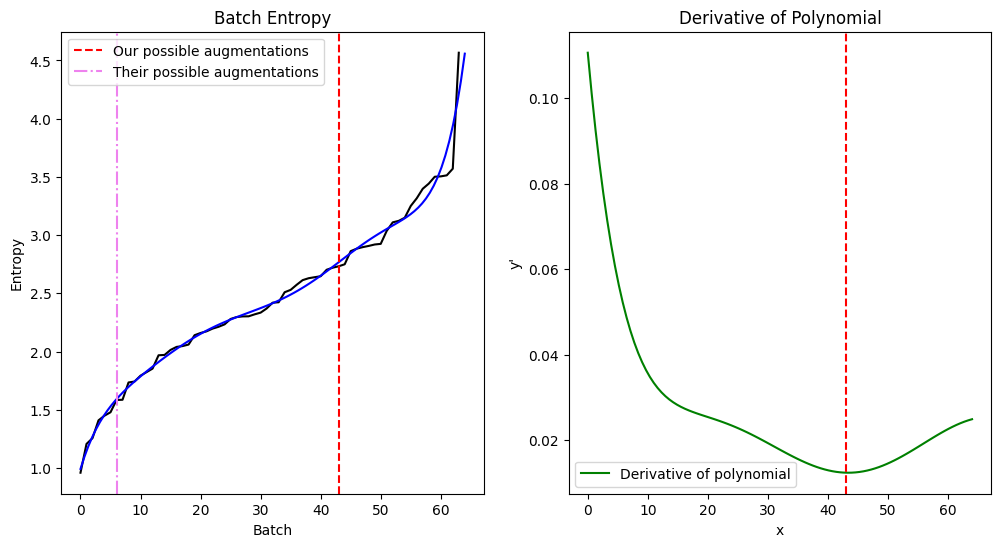

In [ ]:
OUR_SELECTION = True
VISUALIZE_PLOT = True

model.reset_classnames(classnames)

test_time_adapt_eval_visualization(val_loader, model, optimizer, optim_state, scaler)

## 7.4 Running with this selection

In [ ]:
set_random_seed(SEED)

classnames = imagenet_classes

normalize = transforms.Normalize(MEAN, STD)

base_transform = transforms.Compose([
    transforms.Resize(RESOLUTION, interpolation=BICUBIC),
    transforms.CenterCrop(RESOLUTION)])

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize])

data_transform = AugMixAugmenter(base_transform, preprocess, n_views=VIEWS, augmix=False)

batchsize = 1

classnames_all = imagenet_classes

classnames = [classnames_all[i] for i in imagenet_a_mask]

val_dataset = datasets.ImageFolder(DATA, data_transform)

print("number of test samples: {}".format(len(val_dataset)))

val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=batchsize, shuffle=True,
            num_workers=0, pin_memory=True)

number of test samples: 7500


In [ ]:
results = []

OUR_SELECTION = True
DINO = False
VISUALIZE_PLOT = False

set_random_seed(SEED) #for making after the comparison between different results

model = OurCLIP(classnames=classnames, n_ctx=N_CTX, ctx_init=CTX_INIT)

if WEIGHTS is not None:
    print("Use pre-trained soft prompt (CoOp) as initialization")
    pretrained_ctx = torch.load(WEIGHTS)['state_dict']['ctx']
    assert pretrained_ctx.size()[0] == N_CTX
    with torch.no_grad():
        model.prompt_learner.ctx.copy_(pretrained_ctx)
        model.prompt_learner.ctx_init_state = pretrained_ctx

model_state = None

for name, param in model.named_parameters():
    if "prompt_learner" not in name:
        param.requires_grad_(False)

print("=> Model created: visual backbone {}".format(ARCH))

if not torch.cuda.is_available():
    print('using CPU, this will be slow')
else:
    assert GPU is not None
    torch.cuda.set_device(GPU)
    model = model.cuda(GPU)

# define optimizer
trainable_param = model.prompt_learner.parameters()
optimizer = torch.optim.AdamW(trainable_param, LR)
optim_state = deepcopy(optimizer.state_dict())

# setup automatic mixed-precision (Amp) loss scaling
scaler = torch.cuda.amp.GradScaler(init_scale=1000)

print('=> Using native Torch AMP. Training in mixed precision.')

cudnn.benchmark = True

model.reset_classnames(classnames)

results = test_time_adapt_eval(val_loader, model, optimizer, optim_state, scaler)

Random initialization: initializing a generic context
Initial context: "X X X X"
Number of context words (tokens): 4
Use pre-trained soft prompt (CoOp) as initialization
=> Model created: visual backbone RN50
=> Using native Torch AMP. Training in mixed precision.
Test: [   0/7500]	Time  0.873 ( 0.873)	Acc@1   0.00 (  0.00)	Acc@5 100.00 (100.00)
Test: [   1/7500]	Time  0.832 ( 0.852)	Acc@1   0.00 (  0.00)	Acc@5   0.00 ( 50.00)
Test: [   2/7500]	Time  0.825 ( 0.843)	Acc@1   0.00 (  0.00)	Acc@5   0.00 ( 33.33)
Test: [   3/7500]	Time  0.822 ( 0.838)	Acc@1   0.00 (  0.00)	Acc@5   0.00 ( 25.00)
Test: [   4/7500]	Time  0.836 ( 0.838)	Acc@1   0.00 (  0.00)	Acc@5   0.00 ( 20.00)
Test: [   5/7500]	Time  0.811 ( 0.833)	Acc@1 100.00 ( 16.67)	Acc@5 100.00 ( 33.33)
Test: [   6/7500]	Time  0.823 ( 0.832)	Acc@1   0.00 ( 14.29)	Acc@5 100.00 ( 42.86)
Test: [   7/7500]	Time  0.816 ( 0.830)	Acc@1   0.00 ( 12.50)	Acc@5 100.00 ( 50.00)
Test: [   8/7500]	Time  0.909 ( 0.839)	Acc@1   0.00 ( 11.11)	Acc@5 100.

# 8 Second enanchement: Dino augmentations


Our idea was to take advantage of DINO, seeing that it is a self-supervised learning method that does not require labels.
It helps us to calculate the attention map of the image selected, before the application of different augmentation on it.
Indeed, the attention map will underline the main focus of the image and in this way different augmentations can be computed on the basis of that information.

More specifically we will return a list of images composed by
- the original image
- cropped image around its focal point, that has a 30% of probabilities to be horizontally or vertically flipped
- 'basic' augmented images (the one applied also in the original implementation)
- list of cropped image with different threashold for the attention

## 8.1 Dino model

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
Mostly copy-paste from timm library.
https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
"""
import math
from functools import partial
import argparse
import warnings
import torch
import torch.nn as nn
# Copyright (c) Facebook, Inc. and its affiliates.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
Misc functions.

Mostly copy-paste from torchvision references or other public repos like DETR:
https://github.com/facebookresearch/detr/blob/master/util/misc.py
"""
import os
import sys
import time
import math
import random
import datetime
import subprocess
from collections import defaultdict, deque

import numpy as np
import torch
from torch import nn
import torch.distributed as dist
from PIL import ImageFilter, ImageOps


class GaussianBlur(object):
    """
    Apply Gaussian Blur to the PIL image.
    """
    def __init__(self, p=0.5, radius_min=0.1, radius_max=2.):
        self.prob = p
        self.radius_min = radius_min
        self.radius_max = radius_max

    def __call__(self, img):
        do_it = random.random() <= self.prob
        if not do_it:
            return img

        return img.filter(
            ImageFilter.GaussianBlur(
                radius=random.uniform(self.radius_min, self.radius_max)
            )
        )


class Solarization(object):
    """
    Apply Solarization to the PIL image.
    """
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return ImageOps.solarize(img)
        else:
            return img


def load_pretrained_weights(model, pretrained_weights, checkpoint_key, model_name, patch_size):
    if os.path.isfile(pretrained_weights):
        state_dict = torch.load(pretrained_weights, map_location="cpu")
        if checkpoint_key is not None and checkpoint_key in state_dict:
            print(f"Take key {checkpoint_key} in provided checkpoint dict")
            state_dict = state_dict[checkpoint_key]
        # remove `module.` prefix
        state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
        # remove `backbone.` prefix induced by multicrop wrapper
        state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
        msg = model.load_state_dict(state_dict, strict=False)
        print('Pretrained weights found at {} and loaded with msg: {}'.format(pretrained_weights, msg))
    else:
        print("Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.")
        url = None
        if model_name == "vit_small" and patch_size == 16:
            url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"
        elif model_name == "vit_small" and patch_size == 8:
            url = "dino_deitsmall8_pretrain/dino_deitsmall8_pretrain.pth"
        elif model_name == "vit_base" and patch_size == 16:
            url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"
        elif model_name == "vit_base" and patch_size == 8:
            url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
        elif model_name == "xcit_small_12_p16":
            url = "dino_xcit_small_12_p16_pretrain/dino_xcit_small_12_p16_pretrain.pth"
        elif model_name == "xcit_small_12_p8":
            url = "dino_xcit_small_12_p8_pretrain/dino_xcit_small_12_p8_pretrain.pth"
        elif model_name == "xcit_medium_24_p16":
            url = "dino_xcit_medium_24_p16_pretrain/dino_xcit_medium_24_p16_pretrain.pth"
        elif model_name == "xcit_medium_24_p8":
            url = "dino_xcit_medium_24_p8_pretrain/dino_xcit_medium_24_p8_pretrain.pth"
        elif model_name == "resnet50":
            url = "dino_resnet50_pretrain/dino_resnet50_pretrain.pth"
        if url is not None:
            print("Since no pretrained weights have been provided, we load the reference pretrained DINO weights.")
            state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
            model.load_state_dict(state_dict, strict=True)
        else:
            print("There is no reference weights available for this model => We use random weights.")


def load_pretrained_linear_weights(linear_classifier, model_name, patch_size):
    url = None
    if model_name == "vit_small" and patch_size == 16:
        url = "dino_deitsmall16_pretrain/dino_deitsmall16_linearweights.pth"
    elif model_name == "vit_small" and patch_size == 8:
        url = "dino_deitsmall8_pretrain/dino_deitsmall8_linearweights.pth"
    elif model_name == "vit_base" and patch_size == 16:
        url = "dino_vitbase16_pretrain/dino_vitbase16_linearweights.pth"
    elif model_name == "vit_base" and patch_size == 8:
        url = "dino_vitbase8_pretrain/dino_vitbase8_linearweights.pth"
    elif model_name == "resnet50":
        url = "dino_resnet50_pretrain/dino_resnet50_linearweights.pth"
    if url is not None:
        print("We load the reference pretrained linear weights.")
        state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)["state_dict"]
        linear_classifier.load_state_dict(state_dict, strict=True)
    else:
        print("We use random linear weights.")


def clip_gradients(model, clip):
    norms = []
    for name, p in model.named_parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            norms.append(param_norm.item())
            clip_coef = clip / (param_norm + 1e-6)
            if clip_coef < 1:
                p.grad.data.mul_(clip_coef)
    return norms


def cancel_gradients_last_layer(epoch, model, freeze_last_layer):
    if epoch >= freeze_last_layer:
        return
    for n, p in model.named_parameters():
        if "last_layer" in n:
            p.grad = None


def restart_from_checkpoint(ckp_path, run_variables=None, **kwargs):
    """
    Re-start from checkpoint
    """
    if not os.path.isfile(ckp_path):
        return
    print("Found checkpoint at {}".format(ckp_path))

    # open checkpoint file
    checkpoint = torch.load(ckp_path, map_location="cpu")

    # key is what to look for in the checkpoint file
    # value is the object to load
    # example: {'state_dict': model}
    for key, value in kwargs.items():
        if key in checkpoint and value is not None:
            try:
                msg = value.load_state_dict(checkpoint[key], strict=False)
                print("=> loaded '{}' from checkpoint '{}' with msg {}".format(key, ckp_path, msg))
            except TypeError:
                try:
                    msg = value.load_state_dict(checkpoint[key])
                    print("=> loaded '{}' from checkpoint: '{}'".format(key, ckp_path))
                except ValueError:
                    print("=> failed to load '{}' from checkpoint: '{}'".format(key, ckp_path))
        else:
            print("=> key '{}' not found in checkpoint: '{}'".format(key, ckp_path))

    # re load variable important for the run
    if run_variables is not None:
        for var_name in run_variables:
            if var_name in checkpoint:
                run_variables[var_name] = checkpoint[var_name]


def cosine_scheduler(base_value, final_value, epochs, niter_per_ep, warmup_epochs=0, start_warmup_value=0):
    warmup_schedule = np.array([])
    warmup_iters = warmup_epochs * niter_per_ep
    if warmup_epochs > 0:
        warmup_schedule = np.linspace(start_warmup_value, base_value, warmup_iters)

    iters = np.arange(epochs * niter_per_ep - warmup_iters)
    schedule = final_value + 0.5 * (base_value - final_value) * (1 + np.cos(np.pi * iters / len(iters)))

    schedule = np.concatenate((warmup_schedule, schedule))
    assert len(schedule) == epochs * niter_per_ep
    return schedule


def bool_flag(s):
    """
    Parse boolean arguments from the command line.
    """
    FALSY_STRINGS = {"off", "false", "0"}
    TRUTHY_STRINGS = {"on", "true", "1"}
    if s.lower() in FALSY_STRINGS:
        return False
    elif s.lower() in TRUTHY_STRINGS:
        return True
    else:
        raise argparse.ArgumentTypeError("invalid value for a boolean flag")


def fix_random_seeds(seed=31):
    """
    Fix random seeds.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.6f} ({global_avg:.6f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.6f}')
        data_time = SmoothedValue(fmt='{avg:.6f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.6f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def get_sha():
    cwd = os.path.dirname(os.path.abspath(__file__))

    def _run(command):
        return subprocess.check_output(command, cwd=cwd).decode('ascii').strip()
    sha = 'N/A'
    diff = "clean"
    branch = 'N/A'
    try:
        sha = _run(['git', 'rev-parse', 'HEAD'])
        subprocess.check_output(['git', 'diff'], cwd=cwd)
        diff = _run(['git', 'diff-index', 'HEAD'])
        diff = "has uncommited changes" if diff else "clean"
        branch = _run(['git', 'rev-parse', '--abbrev-ref', 'HEAD'])
    except Exception:
        pass
    message = f"sha: {sha}, status: {diff}, branch: {branch}"
    return message


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def init_distributed_mode(args):
    # launched with torch.distributed.launch
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    # launched with submitit on a slurm cluster
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    # launched naively with `python main_dino.py`
    # we manually add MASTER_ADDR and MASTER_PORT to env variables
    elif torch.cuda.is_available():
        print('Will run the code on one GPU.')
        args.rank, args.gpu, args.world_size = 0, 0, 1
        os.environ['MASTER_ADDR'] = '127.0.0.1'
        os.environ['MASTER_PORT'] = '29500'
    else:
        print('Does not support training without GPU.')
        sys.exit(1)

    dist.init_process_group(
        backend="nccl",
        init_method=args.dist_url,
        world_size=args.world_size,
        rank=args.rank,
    )

    torch.cuda.set_device(args.gpu)
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    dist.barrier()
    setup_for_distributed(args.rank == 0)


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:k].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]


def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


class LARS(torch.optim.Optimizer):
    """
    Almost copy-paste from https://github.com/facebookresearch/barlowtwins/blob/main/main.py
    """
    def __init__(self, params, lr=0, weight_decay=0, momentum=0.9, eta=0.001,
                 weight_decay_filter=None, lars_adaptation_filter=None):
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum,
                        eta=eta, weight_decay_filter=weight_decay_filter,
                        lars_adaptation_filter=lars_adaptation_filter)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for g in self.param_groups:
            for p in g['params']:
                dp = p.grad

                if dp is None:
                    continue

                if p.ndim != 1:
                    dp = dp.add(p, alpha=g['weight_decay'])

                if p.ndim != 1:
                    param_norm = torch.norm(p)
                    update_norm = torch.norm(dp)
                    one = torch.ones_like(param_norm)
                    q = torch.where(param_norm > 0.,
                                    torch.where(update_norm > 0,
                                                (g['eta'] * param_norm / update_norm), one), one)
                    dp = dp.mul(q)

                param_state = self.state[p]
                if 'mu' not in param_state:
                    param_state['mu'] = torch.zeros_like(p)
                mu = param_state['mu']
                mu.mul_(g['momentum']).add_(dp)

                p.add_(mu, alpha=-g['lr'])


class MultiCropWrapper(nn.Module):
    """
    Perform forward pass separately on each resolution input.
    The inputs corresponding to a single resolution are clubbed and single
    forward is run on the same resolution inputs. Hence we do several
    forward passes = number of different resolutions used. We then
    concatenate all the output features and run the head forward on these
    concatenated features.
    """
    def __init__(self, backbone, head):
        super(MultiCropWrapper, self).__init__()
        # disable layers dedicated to ImageNet labels classification
        backbone.fc, backbone.head = nn.Identity(), nn.Identity()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        # convert to list
        if not isinstance(x, list):
            x = [x]
        idx_crops = torch.cumsum(torch.unique_consecutive(
            torch.tensor([inp.shape[-1] for inp in x]),
            return_counts=True,
        )[1], 0)
        start_idx, output = 0, torch.empty(0).to(x[0].device)
        for end_idx in idx_crops:
            _out = self.backbone(torch.cat(x[start_idx: end_idx]))
            # The output is a tuple with XCiT model. See:
            # https://github.com/facebookresearch/xcit/blob/master/xcit.py#L404-L405
            if isinstance(_out, tuple):
                _out = _out[0]
            # accumulate outputs
            output = torch.cat((output, _out))
            start_idx = end_idx
        # Run the head forward on the concatenated features.
        return self.head(output)


def get_params_groups(model):
    regularized = []
    not_regularized = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        # we do not regularize biases nor Norm parameters
        if name.endswith(".bias") or len(param.shape) == 1:
            not_regularized.append(param)
        else:
            regularized.append(param)
    return [{'params': regularized}, {'params': not_regularized, 'weight_decay': 0.}]


def has_batchnorms(model):
    bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.SyncBatchNorm)
    for name, module in model.named_modules():
        if isinstance(module, bn_types):
            return True
    return False


class PCA():
    """
    Class to  compute and apply PCA.
    """
    def __init__(self, dim=256, whit=0.5):
        self.dim = dim
        self.whit = whit
        self.mean = None

    def train_pca(self, cov):
        """
        Takes a covariance matrix (np.ndarray) as input.
        """
        d, v = np.linalg.eigh(cov)
        eps = d.max() * 1e-5
        n_0 = (d < eps).sum()
        if n_0 > 0:
            d[d < eps] = eps

        # total energy
        totenergy = d.sum()

        # sort eigenvectors with eigenvalues order
        idx = np.argsort(d)[::-1][:self.dim]
        d = d[idx]
        v = v[:, idx]

        print("keeping %.2f %% of the energy" % (d.sum() / totenergy * 100.0))

        # for the whitening
        d = np.diag(1. / d**self.whit)

        # principal components
        self.dvt = np.dot(d, v.T)

    def apply(self, x):
        # input is from numpy
        if isinstance(x, np.ndarray):
            if self.mean is not None:
                x -= self.mean
            return np.dot(self.dvt, x.T).T

        # input is from torch and is on GPU
        if x.is_cuda:
            if self.mean is not None:
                x -= torch.cuda.FloatTensor(self.mean)
            return torch.mm(torch.cuda.FloatTensor(self.dvt), x.transpose(0, 1)).transpose(0, 1)

        # input if from torch, on CPU
        if self.mean is not None:
            x -= torch.FloatTensor(self.mean)
        return torch.mm(torch.FloatTensor(self.dvt), x.transpose(0, 1)).transpose(0, 1)


def compute_ap(ranks, nres):
    """
    Computes average precision for given ranked indexes.
    Arguments
    ---------
    ranks : zerro-based ranks of positive images
    nres  : number of positive images
    Returns
    -------
    ap    : average precision
    """

    # number of images ranked by the system
    nimgranks = len(ranks)

    # accumulate trapezoids in PR-plot
    ap = 0

    recall_step = 1. / nres

    for j in np.arange(nimgranks):
        rank = ranks[j]

        if rank == 0:
            precision_0 = 1.
        else:
            precision_0 = float(j) / rank

        precision_1 = float(j + 1) / (rank + 1)

        ap += (precision_0 + precision_1) * recall_step / 2.

    return ap


def compute_map(ranks, gnd, kappas=[]):
    """
    Computes the mAP for a given set of returned results.
         Usage:
           map = compute_map (ranks, gnd)
                 computes mean average precsion (map) only
           map, aps, pr, prs = compute_map (ranks, gnd, kappas)
                 computes mean average precision (map), average precision (aps) for each query
                 computes mean precision at kappas (pr), precision at kappas (prs) for each query
         Notes:
         1) ranks starts from 0, ranks.shape = db_size X #queries
         2) The junk results (e.g., the query itself) should be declared in the gnd stuct array
         3) If there are no positive images for some query, that query is excluded from the evaluation
    """

    map = 0.
    nq = len(gnd) # number of queries
    aps = np.zeros(nq)
    pr = np.zeros(len(kappas))
    prs = np.zeros((nq, len(kappas)))
    nempty = 0

    for i in np.arange(nq):
        qgnd = np.array(gnd[i]['ok'])

        # no positive images, skip from the average
        if qgnd.shape[0] == 0:
            aps[i] = float('nan')
            prs[i, :] = float('nan')
            nempty += 1
            continue

        try:
            qgndj = np.array(gnd[i]['junk'])
        except:
            qgndj = np.empty(0)

        # sorted positions of positive and junk images (0 based)
        pos  = np.arange(ranks.shape[0])[np.in1d(ranks[:,i], qgnd)]
        junk = np.arange(ranks.shape[0])[np.in1d(ranks[:,i], qgndj)]

        k = 0;
        ij = 0;
        if len(junk):
            # decrease positions of positives based on the number of
            # junk images appearing before them
            ip = 0
            while (ip < len(pos)):
                while (ij < len(junk) and pos[ip] > junk[ij]):
                    k += 1
                    ij += 1
                pos[ip] = pos[ip] - k
                ip += 1

        # compute ap
        ap = compute_ap(pos, len(qgnd))
        map = map + ap
        aps[i] = ap

        # compute precision @ k
        pos += 1 # get it to 1-based
        for j in np.arange(len(kappas)):
            kq = min(max(pos), kappas[j]);
            prs[i, j] = (pos <= kq).sum() / kq
        pr = pr + prs[i, :]

    map = map / (nq - nempty)
    pr = pr / (nq - nempty)

    return map, aps, pr, prs


def multi_scale(samples, model):
    v = None
    for s in [1, 1/2**(1/2), 1/2]:  # we use 3 different scales
        if s == 1:
            inp = samples.clone()
        else:
            inp = nn.functional.interpolate(samples, scale_factor=s, mode='bilinear', align_corners=False)
        feats = model(inp).clone()
        if v is None:
            v = feats
        else:
            v += feats
    v /= 3
    v /= v.norm()
    return v



def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self, img_size=[224], patch_size=16, in_chans=3, num_classes=0, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = PatchEmbed(
            img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, w, h):
        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1
        if npatch == N and w == h:
            return self.pos_embed
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    def prepare_tokens(self, x):
        B, nc, w, h = x.shape
        x = self.patch_embed(x)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.interpolate_pos_encoding(x, w, h)

        return self.pos_drop(x)

    def forward(self, x):
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x[:, 0]

    def get_last_selfattention(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                x = blk(x)
            else:
                # return attention of the last block
                return blk(x, return_attention=True)

    def get_intermediate_layers(self, x, n=1):
        x = self.prepare_tokens(x)
        # we return the output tokens from the `n` last blocks
        output = []
        for i, blk in enumerate(self.blocks):
            x = blk(x)
            if len(self.blocks) - i <= n:
                output.append(self.norm(x))
        return output


def vit_tiny(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_small(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_base(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim, use_bn=False, norm_last_layer=True, nlayers=3, hidden_dim=2048, bottleneck_dim=256):
        super().__init__()
        nlayers = max(nlayers, 1)
        if nlayers == 1:
            self.mlp = nn.Linear(in_dim, bottleneck_dim)
        else:
            layers = [nn.Linear(in_dim, hidden_dim)]
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.GELU())
            for _ in range(nlayers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                if use_bn:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                layers.append(nn.GELU())
            layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            self.mlp = nn.Sequential(*layers)
        self.apply(self._init_weights)
        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1)
        if norm_last_layer:
            self.last_layer.weight_g.requires_grad = False

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.mlp(x)
        x = nn.functional.normalize(x, dim=-1, p=2)
        x = self.last_layer(x)
        return x


## 8.2 Attention


In the model dino in order to have the attention map of an image different "heads" are employed to capture various aspects or features of the data.

In [ ]:
def get_attention_maps(img, model, arch='vit_small', patch_size=8, checkpoint_key='teacher'):

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Open and preprocess the image
    img = img.unsqueeze(0).to(device)

    # Make the image divisible by the patch size
    w, h = img.shape[2] - img.shape[2] % patch_size, img.shape[3] - img.shape[3] % patch_size
    img = img[:, :, :w, :h]

    # Get attention maps
    attentions = model.get_last_selfattention(img)

    nh = attentions.shape[1]  # number of heads
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w // patch_size, h // patch_size)
    attentions = torch.nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

    return attentions

## 8.3 Augmentations

In [ ]:
class AttentionGuidedAugmenter(object):
    def __init__(self, base_transform, preprocess, model_dino, n_views=2, augmix=False, severity=1):
        self.base_transform = base_transform
        self.preprocess = preprocess
        self.n_views = n_views
        self.augmix = augmix
        self.severity = severity
        self.model_dino = model_dino
        self.aug_list = []

    def __call__(self, x):
        image = self.preprocess(self.base_transform(x))

        # find attention map for the image
        attention_maps = get_attention_maps(image, self.model_dino)
        list_of_tensors = [torch.tensor(tensor) for tensor in attention_maps]
        attention_map = torch.mean(torch.stack(list_of_tensors), dim=0)
        attention_map = attention_map / attention_map.sum() #normalize the att

        cropped = []
        cropped.append(find_bounding_box(attention_map, image, 0.1))
        cropped.append(find_bounding_box(attention_map, image, 0.25))
        cropped.append(find_bounding_box(attention_map, image, 0.3))
        cropped.append(find_bounding_box(attention_map, image, 0.5))
        max_idx = torch.argmax(attention_map)

        focal_point = np.unravel_index(max_idx.item(), attention_map.shape) #select a focal point based on attention
        attention_views = [self.augment_view(image, focal_point=focal_point) for _ in range(int(self.n_views/2))]

        normal_views = [augmix(x, self.preprocess, self.aug_list, self.severity) for _ in range(int(self.n_views/2))]
        return [image] + attention_views + normal_views + cropped

    def augment_view(self, x, focal_point):

        augmented_img = self.crop_with_focal_point(x, focal_point, (random.randint(80, 140),random.randint(80, 140)), variance=0.4) #aug according to focal_point
        augmented_img = self.random_horizontal_flip(augmented_img, 0.3) # flip it
        augmented_img = self.random_vertical_flip(augmented_img, 0.3)
        return augmented_img

    def save_attentions(self,attentions):

        for j in range(6):
            fname = os.path.join("informations", "attn-head" + str(j) + ".png")
            plt.imsave(fname=fname, arr=attentions[j], format='png')
            plt.close()

    #crop an image tensor centered around a focal point with some variance
    def crop_with_focal_point(self, image, focal_point, crop_size, variance=0.1):

        H, W = 224, 224
        crop_height, crop_width = crop_size
        focal_x, focal_y = focal_point[0], focal_point[1]
        resize = transforms.Resize((224,224), antialias=True)

        #apply variance to focal point
        offset_x = int((random.random() - 0.5) * 2 * variance * crop_width)
        offset_y = int((random.random() - 0.5) * 2 * variance * crop_height)
        focal_x = min(max(focal_x + offset_x, 0), W)
        focal_y = min(max(focal_y + offset_y, 0), H)

        #compute crop boundaries
        x1 = max(focal_x - crop_width // 2, 0)
        y1 = max(focal_y - crop_height // 2, 0)
        x2 = min(x1 + crop_width, W)
        y2 = min(y1 + crop_height, H)

        #adjust x1 and y1 if the crop size exceeds image dimensions
        x1 = x2 - crop_width if x2 - crop_width < 0 else x1
        y1 = y2 - crop_height if y2 - crop_height < 0 else y1

        #cropping
        cropped_image = image[:, y1:y2, x1:x2]
        cropped_image = resize(cropped_image)

        return cropped_image

    def random_horizontal_flip(self, image, p_flip):
        prob = random.random()

        if prob > (1-p_flip):
            image = torch.flip(image, [2])

        return image

    def random_vertical_flip(self, image, p_flip):
        prob = random.random()

        if prob > (1-p_flip):
            image = torch.flip(image, [1])

        return image

The following function is used to get the most possible correct augmented image. In particular with its usage, we can obtain the bouding boxes that capture the quantity of attention specified in the given threashold.
For apply this process, we create a binary mask that keeps only the attention values which are above the threshold.
The contours are then found thanks to the usage of OpenCV library.
Finally, the cropped image is returned.  

In [ ]:
def find_bounding_box(attention_tensor, original_tensor, percentage):

    # Unnormalization function for the images
    unnormalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(MEAN, STD)],
        std=[1/s for s in STD]
    )
    original_tensor = unnormalize(original_tensor)

    attention_map = attention_tensor.numpy() #convert to numpy for processing

    original_image = original_tensor.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    original_image = (original_image * 255).astype(np.uint8)  # Scale to 0-255 if necessary
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Calculate the necessary threshold
    flat_map = attention_map.flatten()
    max_value = max(flat_map)

    # Create a binary mask
    mask = (attention_map >= max_value*percentage).astype(np.uint8) * 255

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return original_image, (0, 0, 0, 0)  # No contour found

    # Assuming the largest contour is the region of interest
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Draw the bounding box on the original image
    if original_image.dtype != np.uint8:
        original_image = (original_image * 255).astype(np.uint8)  # Scale and convert to uint8 if not already
    original_image = np.ascontiguousarray(original_image)
    cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.imwrite(f"informations/crop_info_{percentage}.png", original_image)
    resize = transforms.Resize((224,224), antialias=True)
    cropped_image = resize(original_tensor[:, y:y+h, x:x+w])

    return cropped_image

## 8.4 Example


Take one image from the dataset and display it

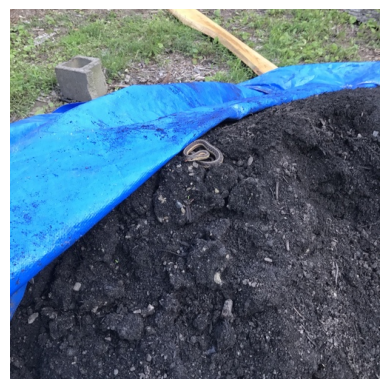

In [ ]:
# Different images to try

# image_path = "/content/imagenet-a/n02454379/0.041826_shovel _ shovel_0.31965467.jpg"
image_path = "/content/imagenet-a/n01735189/0.000011_sleeping bag _ sleeping bag_0.8492054.jpg"
# image_path = "/content/imagenet-a/n02454379/0.010777_porcupine _ porcupine_0.33870572.jpg"
# put other path for testing other images

plt.imshow(plt.imread(image_path))
plt.axis('off')
plt.show()

Compute the attention heads with dino for this image. In order to use all the information captured by all the heads,we create a global attention map merging together all the attention maps from the different heads.

Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall8_300ep_pretrain.pth
100%|██████████| 82.7M/82.7M [00:05<00:00, 16.9MB/s]


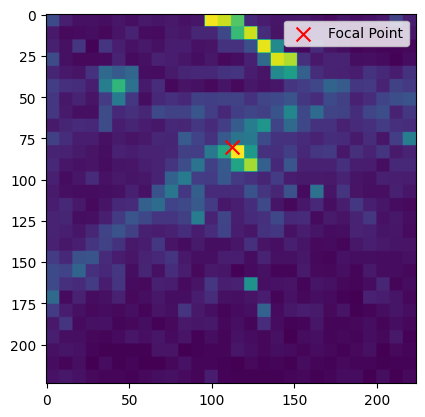

In [ ]:
arch='vit_small'
patch_size=8
checkpoint_key='teacher'
model_dino = vit_small(patch_size=patch_size, num_classes=0)
for p in model_dino.parameters():
    p.requires_grad = False
model_dino.eval()
device = "cuda"
model_dino.to(device)

#load the weights
url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"
state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
if checkpoint_key in state_dict:
    state_dict = state_dict[checkpoint_key]
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
model_dino.load_state_dict(state_dict, strict=False)

#calculation of the attention map and show it
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD),
    ])

image = Image.open(image_path)

image = transform(image)

attention_maps = get_attention_maps(image, model_dino)
list_of_tensors = [torch.tensor(tensor) for tensor in attention_maps]
attention_map = torch.mean(torch.stack(list_of_tensors), dim=0)
attention_map = attention_map / attention_map.sum()

max_idx = torch.argmax(attention_map)
focal_point = np.unravel_index(max_idx.item(), attention_map.shape)

plt.imshow(attention_map)
plt.scatter([focal_point[1]],
            [focal_point[0]],
            color='red', s=100, marker='x', label='Focal Point')
plt.legend()
plt.show()
plt.show()

Display the aumentations that we create with the attention heads

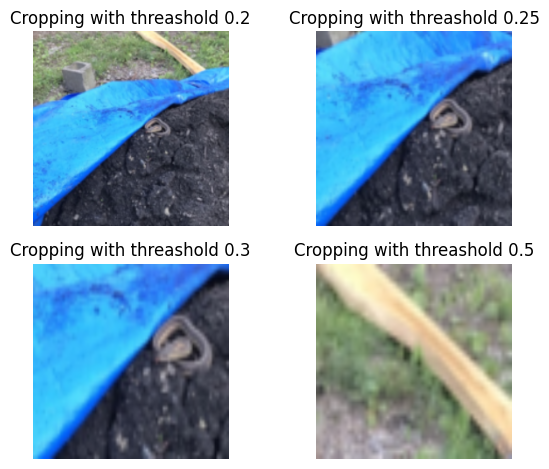

In [ ]:
cropped_02 = find_bounding_box(attention_map, image, 0.2)
cropped_025 = find_bounding_box(attention_map, image, 0.25)
cropped_03 = find_bounding_box(attention_map, image, 0.3)
cropped_05 = find_bounding_box(attention_map, image, 0.5)

# permute for plt
cropped_02 = cropped_02.permute(1, 2, 0)
cropped_025 = cropped_025.permute(1, 2, 0)
cropped_03 = cropped_03.permute(1, 2, 0)
cropped_05 = cropped_05.permute(1, 2, 0)

# display the images
fig, axs = plt.subplots(2, 2)
# Display each image in a subplot
axs[0, 0].imshow(cropped_02, cmap='gray')
axs[0, 0].set_title('Cropping with threashold 0.2')
axs[0, 0].axis('off')

axs[0, 1].imshow(cropped_025, cmap='gray')
axs[0, 1].set_title('Cropping with threashold 0.25')
axs[0, 1].axis('off')

axs[1, 0].imshow(cropped_03, cmap='gray')
axs[1, 0].set_title('Cropping with threashold 0.3')
axs[1, 0].axis('off')

axs[1, 1].imshow(cropped_05, cmap='gray')
axs[1, 1].set_title('Cropping with threashold 0.5')
axs[1, 1].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Then in the `AttentionGuidedAugmentation` class, random horizontal flip and vertical flip are applied in order to obtain better augmentations.

## 8.5 Run with dino augmentations

### 8.5.1 Recreate the dataset with dino augmentations

In [ ]:
set_random_seed(SEED)

classnames = imagenet_classes

normalize = transforms.Normalize(MEAN, STD)

base_transform = transforms.Compose([
    transforms.Resize(RESOLUTION, interpolation=BICUBIC),
    transforms.CenterCrop(RESOLUTION)])

preprocess = transforms.Compose([
              transforms.ToTensor(),
              normalize])

data_transform = AttentionGuidedAugmenter(base_transform, preprocess, model_dino, n_views=VIEWS, augmix=False)

batchsize = 1

classnames_all = imagenet_classes

classnames = [classnames_all[i] for i in imagenet_a_mask]

val_dataset = datasets.ImageFolder(DATA, data_transform)

print("number of test samples: {}".format(len(val_dataset)))

val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=batchsize, shuffle=True,
            num_workers=0, pin_memory=True)

number of test samples: 7500


### 8.5.2 Run it!

In [ ]:
results = []

OUR_SELECTION = False
DINO = True

set_random_seed(SEED) #for making after the comparison between different results

model = OurCLIP(classnames=classnames, n_ctx=N_CTX, ctx_init=CTX_INIT)

if WEIGHTS is not None:
    print("Use pre-trained soft prompt (CoOp) as initialization")
    pretrained_ctx = torch.load(WEIGHTS)['state_dict']['ctx']
    assert pretrained_ctx.size()[0] == N_CTX
    with torch.no_grad():
        model.prompt_learner.ctx.copy_(pretrained_ctx)
        model.prompt_learner.ctx_init_state = pretrained_ctx

model_state = None

for name, param in model.named_parameters():
    if "prompt_learner" not in name:
        param.requires_grad_(False)

print("=> Model created: visual backbone {}".format(ARCH))

if not torch.cuda.is_available():
    print('using CPU, this will be slow')
else:
    assert GPU is not None
    torch.cuda.set_device(GPU)
    model = model.cuda(GPU)

# define optimizer
trainable_param = model.prompt_learner.parameters()
optimizer = torch.optim.AdamW(trainable_param, LR)
optim_state = deepcopy(optimizer.state_dict())

# setup automatic mixed-precision (Amp) loss scaling
scaler = torch.cuda.amp.GradScaler(init_scale=1000)

print('=> Using native Torch AMP. Training in mixed precision.')

cudnn.benchmark = True

model.reset_classnames(classnames)

results = test_time_adapt_eval(val_loader, model, optimizer, optim_state, scaler)

Random initialization: initializing a generic context
Initial context: "X X X X"
Number of context words (tokens): 4
Use pre-trained soft prompt (CoOp) as initialization
=> Model created: visual backbone RN50
=> Using native Torch AMP. Training in mixed precision.
Test: [   0/7500]	Time  1.966 ( 1.966)	Acc@1   0.00 (  0.00)	Acc@5 100.00 (100.00)
Test: [   1/7500]	Time  0.999 ( 1.483)	Acc@1   0.00 (  0.00)	Acc@5 100.00 (100.00)
Test: [   2/7500]	Time  1.513 ( 1.493)	Acc@1   0.00 (  0.00)	Acc@5   0.00 ( 66.67)
Test: [   3/7500]	Time  1.317 ( 1.449)	Acc@1   0.00 (  0.00)	Acc@5   0.00 ( 50.00)
Test: [   4/7500]	Time  1.391 ( 1.437)	Acc@1   0.00 (  0.00)	Acc@5   0.00 ( 40.00)
Test: [   5/7500]	Time  1.116 ( 1.384)	Acc@1   0.00 (  0.00)	Acc@5 100.00 ( 50.00)
Test: [   6/7500]	Time  1.483 ( 1.398)	Acc@1   0.00 (  0.00)	Acc@5 100.00 ( 57.14)
Test: [   7/7500]	Time  1.271 ( 1.382)	Acc@1   0.00 (  0.00)	Acc@5 100.00 ( 62.50)
Test: [   8/7500]	Time  0.855 ( 1.323)	Acc@1   0.00 (  0.00)	Acc@5 100.

# 9 Results and conclusion

## 9.1 Comparison between our selection criteria and TPT

Below, a list of the correct predicted images and the one missed by our code respect to TPT. In our opinion, sometimes this algorithm fails to improve because it selects the best augmentations with minor losses. Since we use the losses to update our model, this can sometimes cause small updates that lead to wrose predictions.
Said that we also think that from a theoretical point of view, a more coherent representation for one sample is given by selecting more augmentations.

The fact that sometimes our selection method works and sometimes not confirms these facts.

Example of cases where our method outperforms standard TPT:

Our selected augmentation:

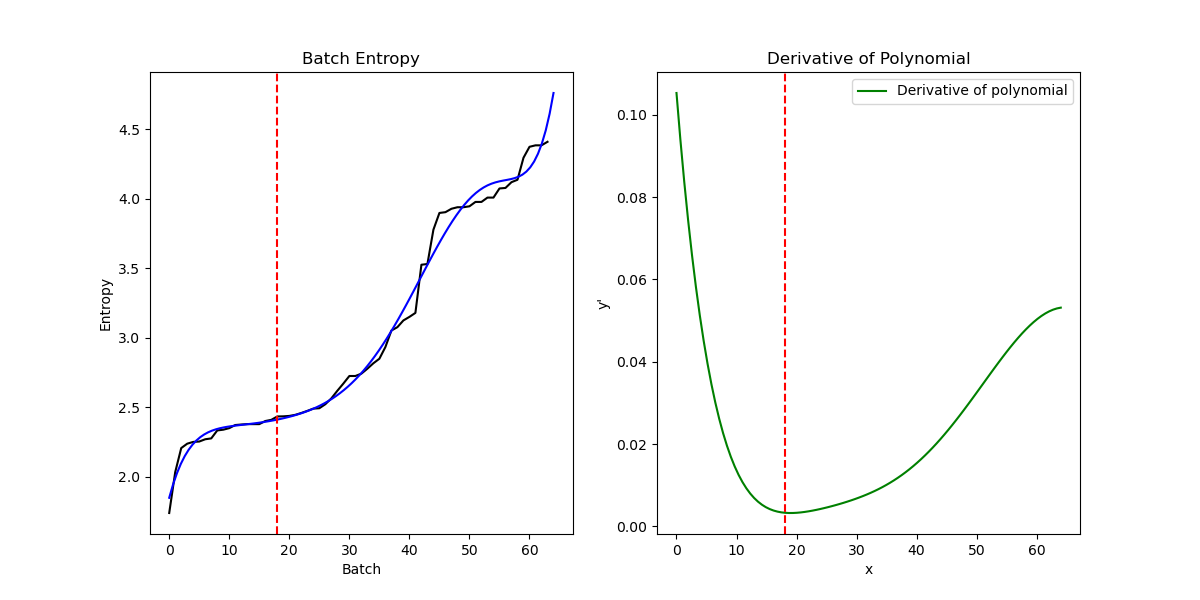

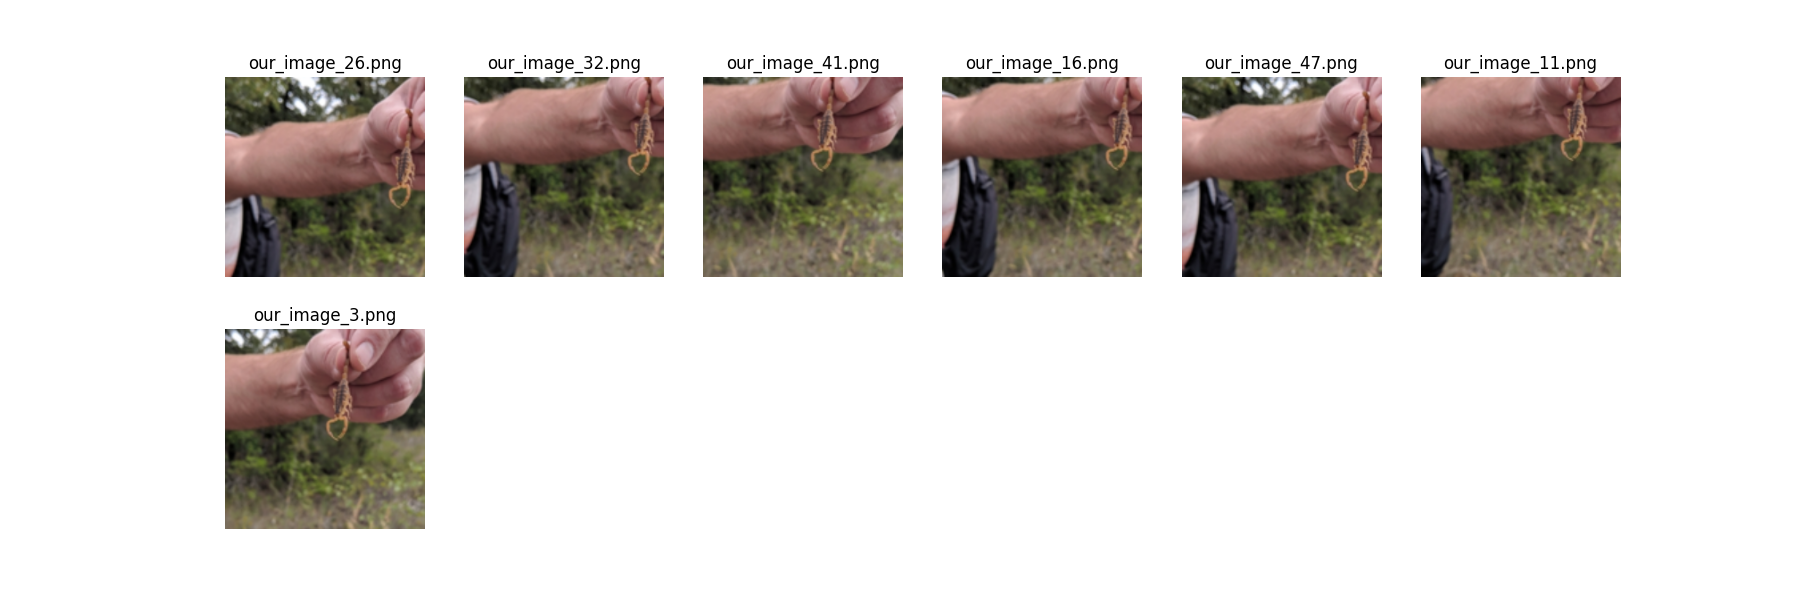

Their selected augmentation:

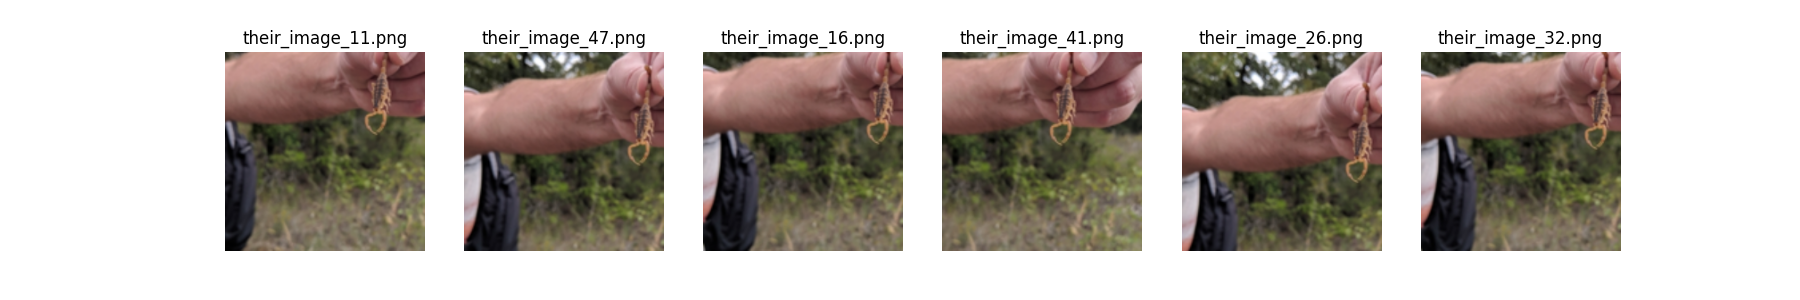

In this example including the "our_image_3" gives a positive effect, as aspected and explained before.

------------------------------------------------------------------------------

Example where our method is outperformed by the default one.

Our selected augmentations and a visual representation of it:

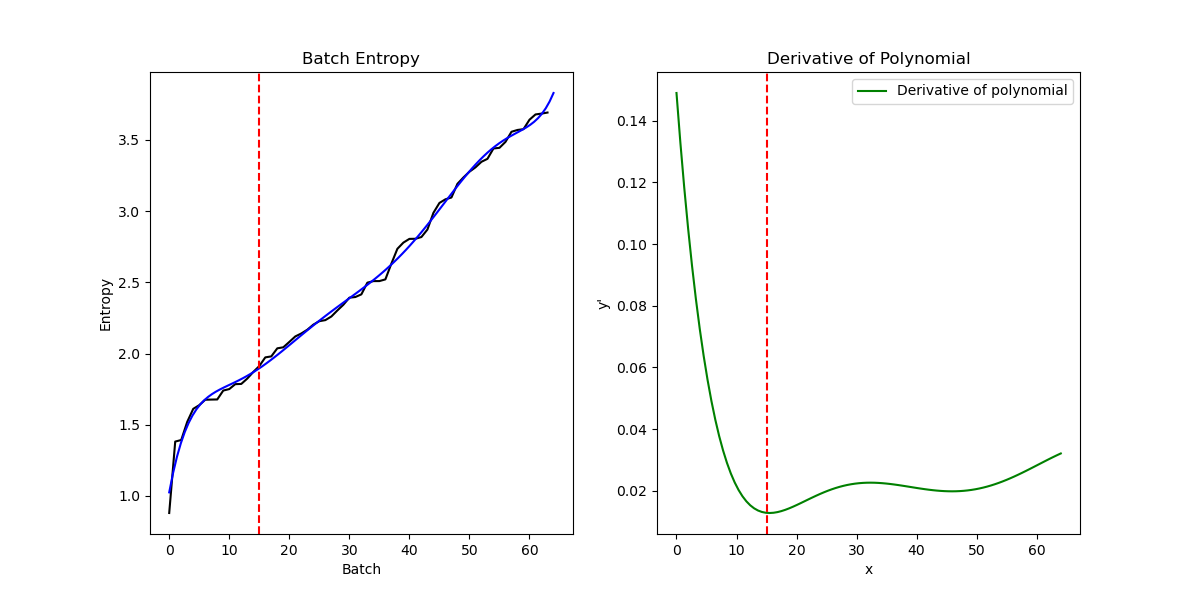

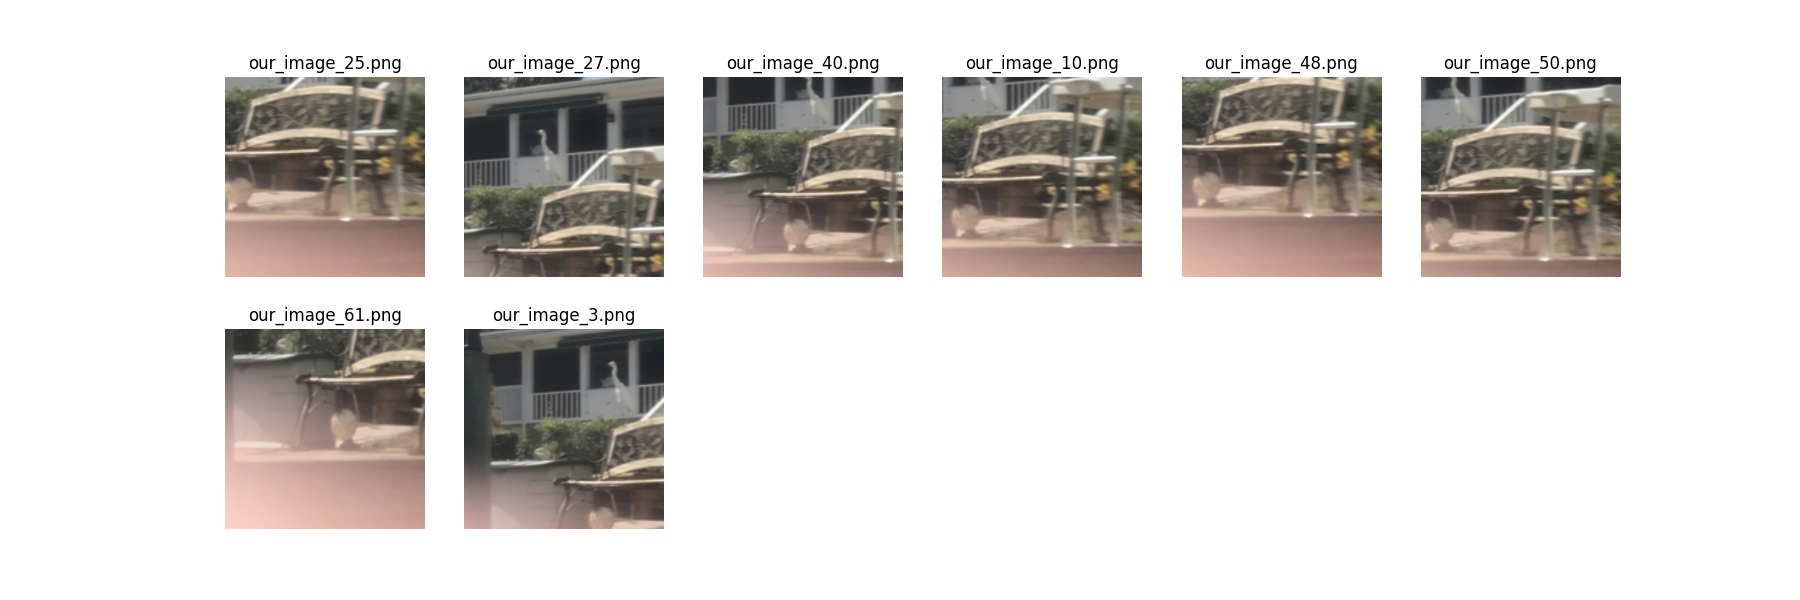

Their selected augmentations:

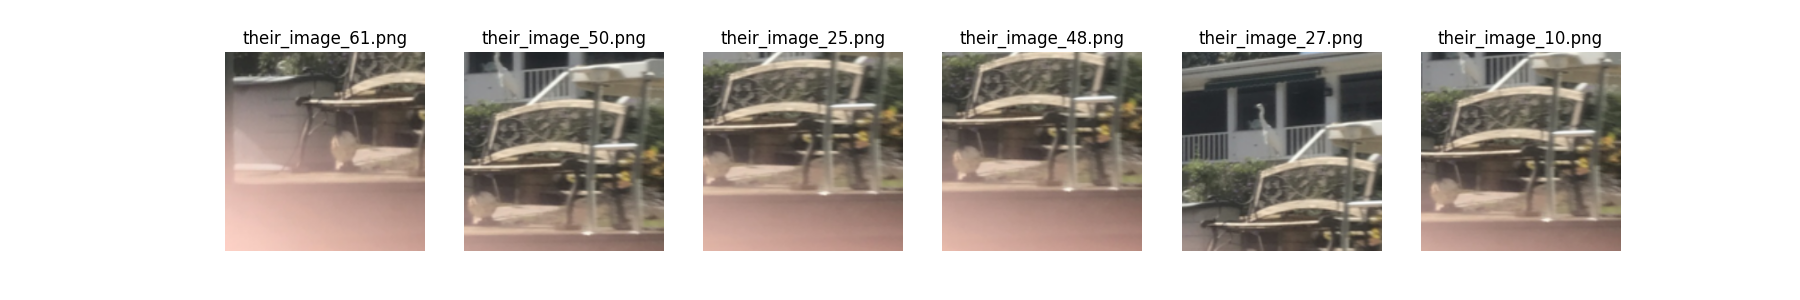

In this case, our method includs also `our_image_40.png` and `our_image_3.png`. Although both contain the subject and these are even better augmentations than the other selected by both methods, the results obtained lead to a worst prediction.

## 9.2 Comparison between the usage of DINO model in the code and TPT

The usage of DINO model was introduced in order to create augmenations which aim to contain the most amount of information of each image. We have implemented the creation of these augmentations according to the attention map generated by the DINO model. In this way, for the most of the time, augmentations place the attention on the right subject of the photo.

In any case, it could happend that the DINO model predicts a bad attention map leading our augmentation on the wrong track.

Below, a list of examples where the DINO model gives a positive contribution to the TTA method and one in which the results lead to a worst prediction.



Here an example of the augmentations that we have generated using DINO.

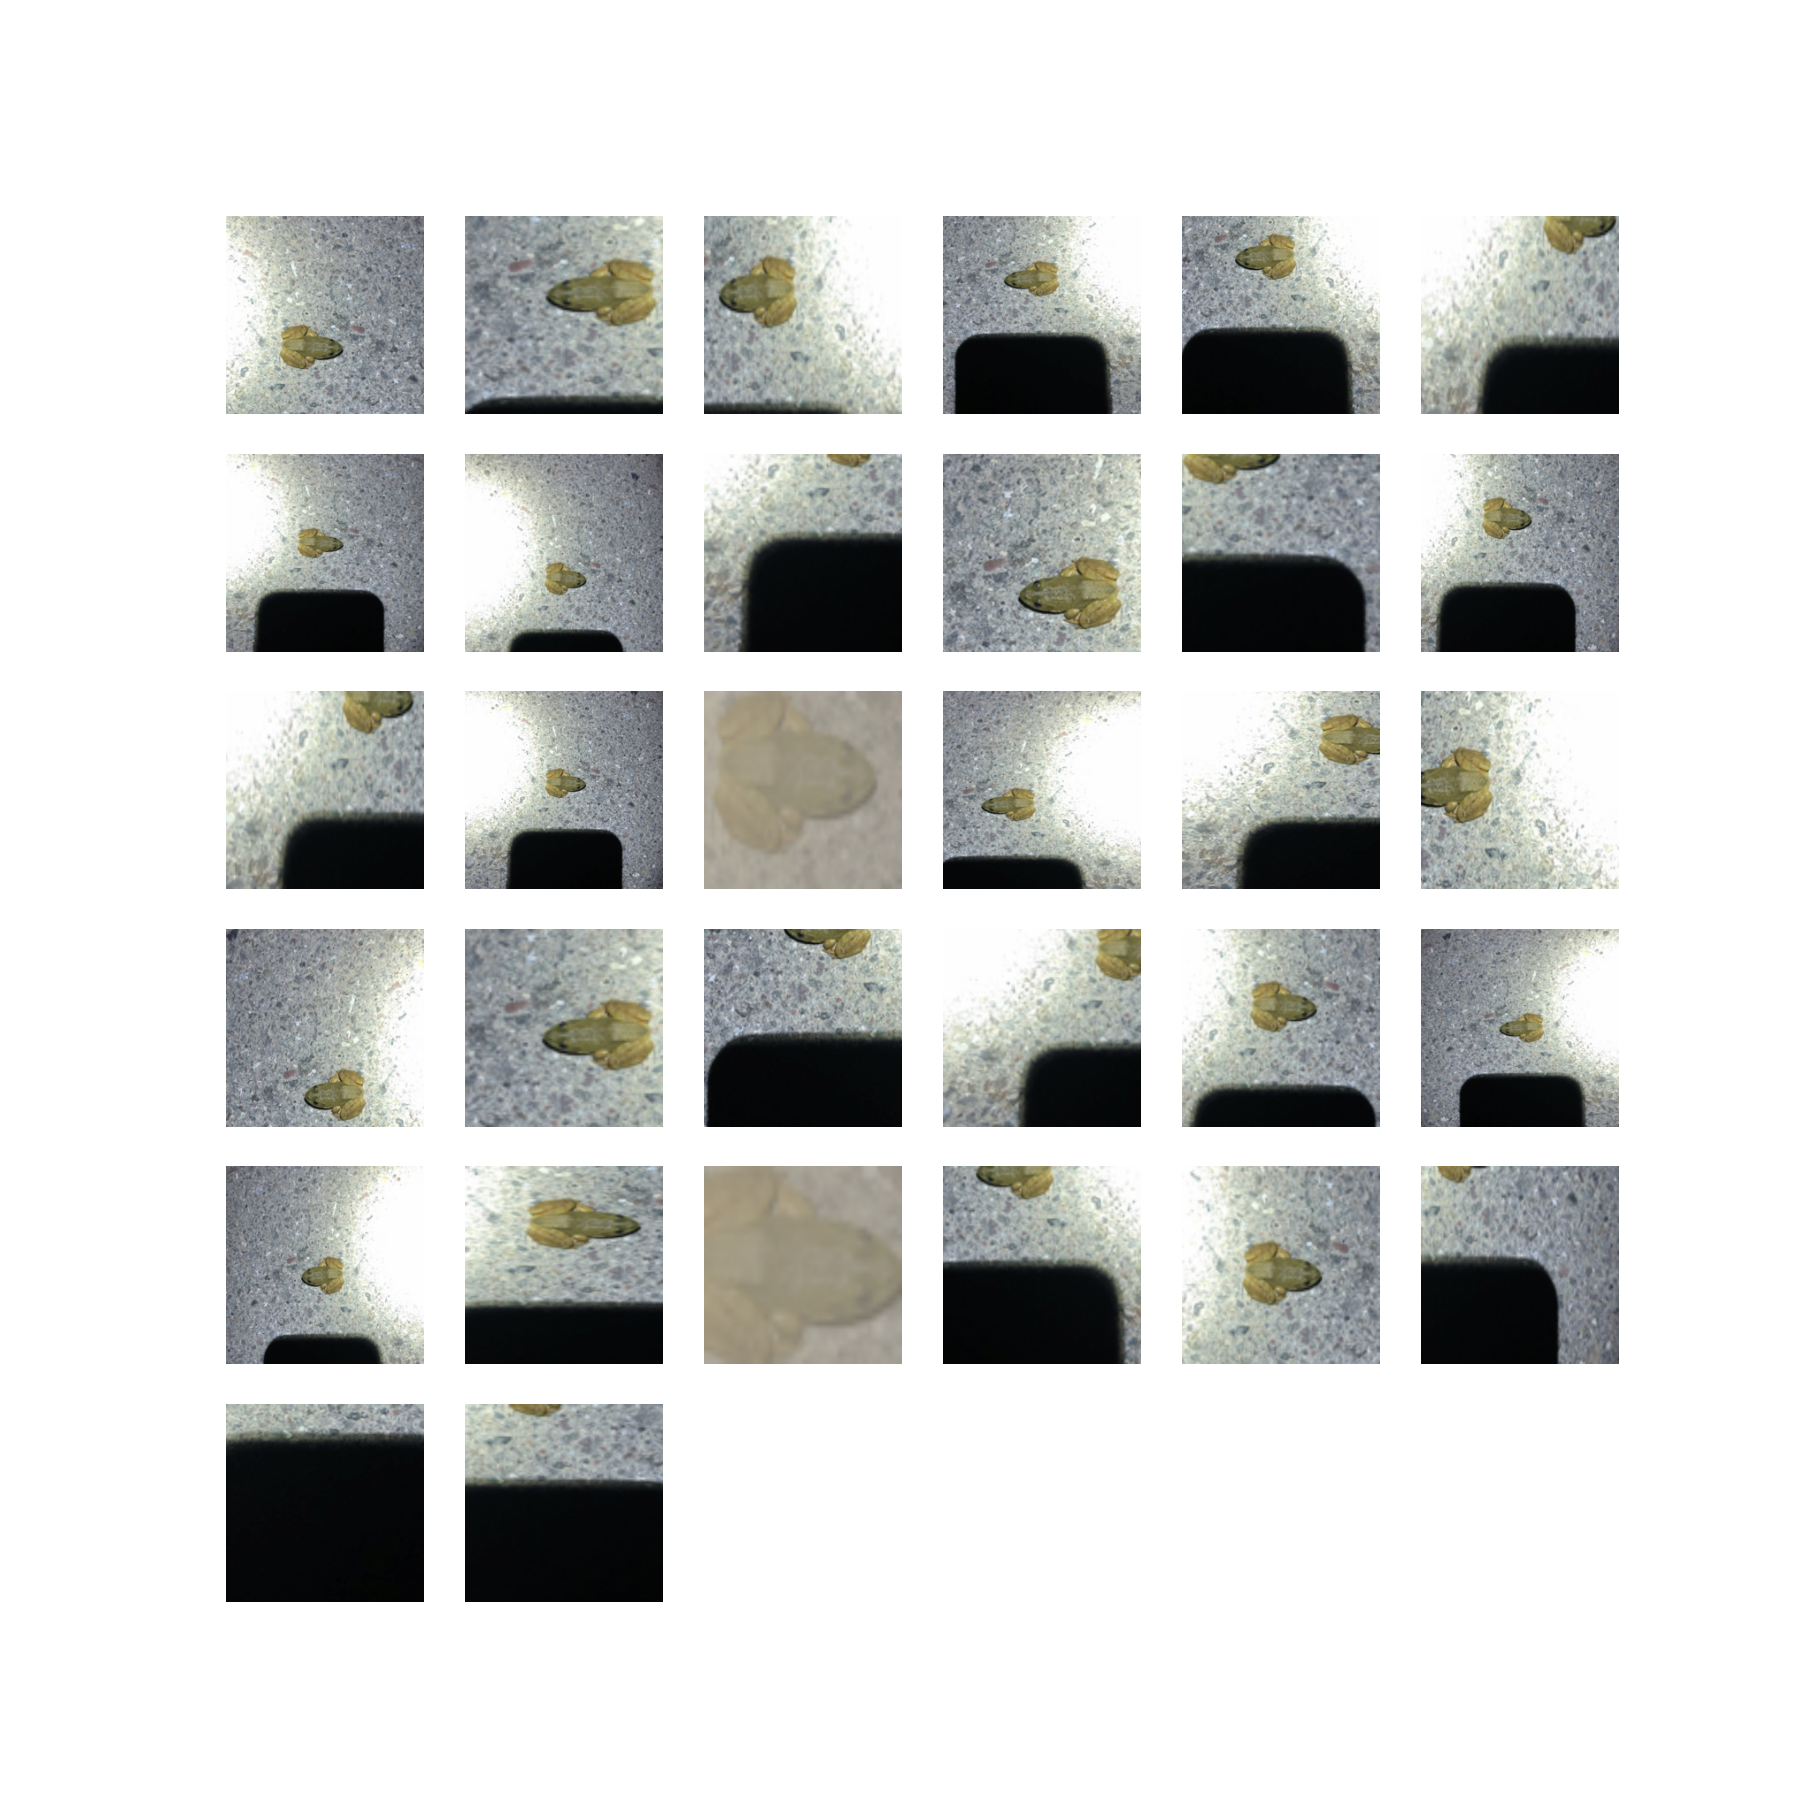

------------------------------------------

Here the augmentations generated without DINO:





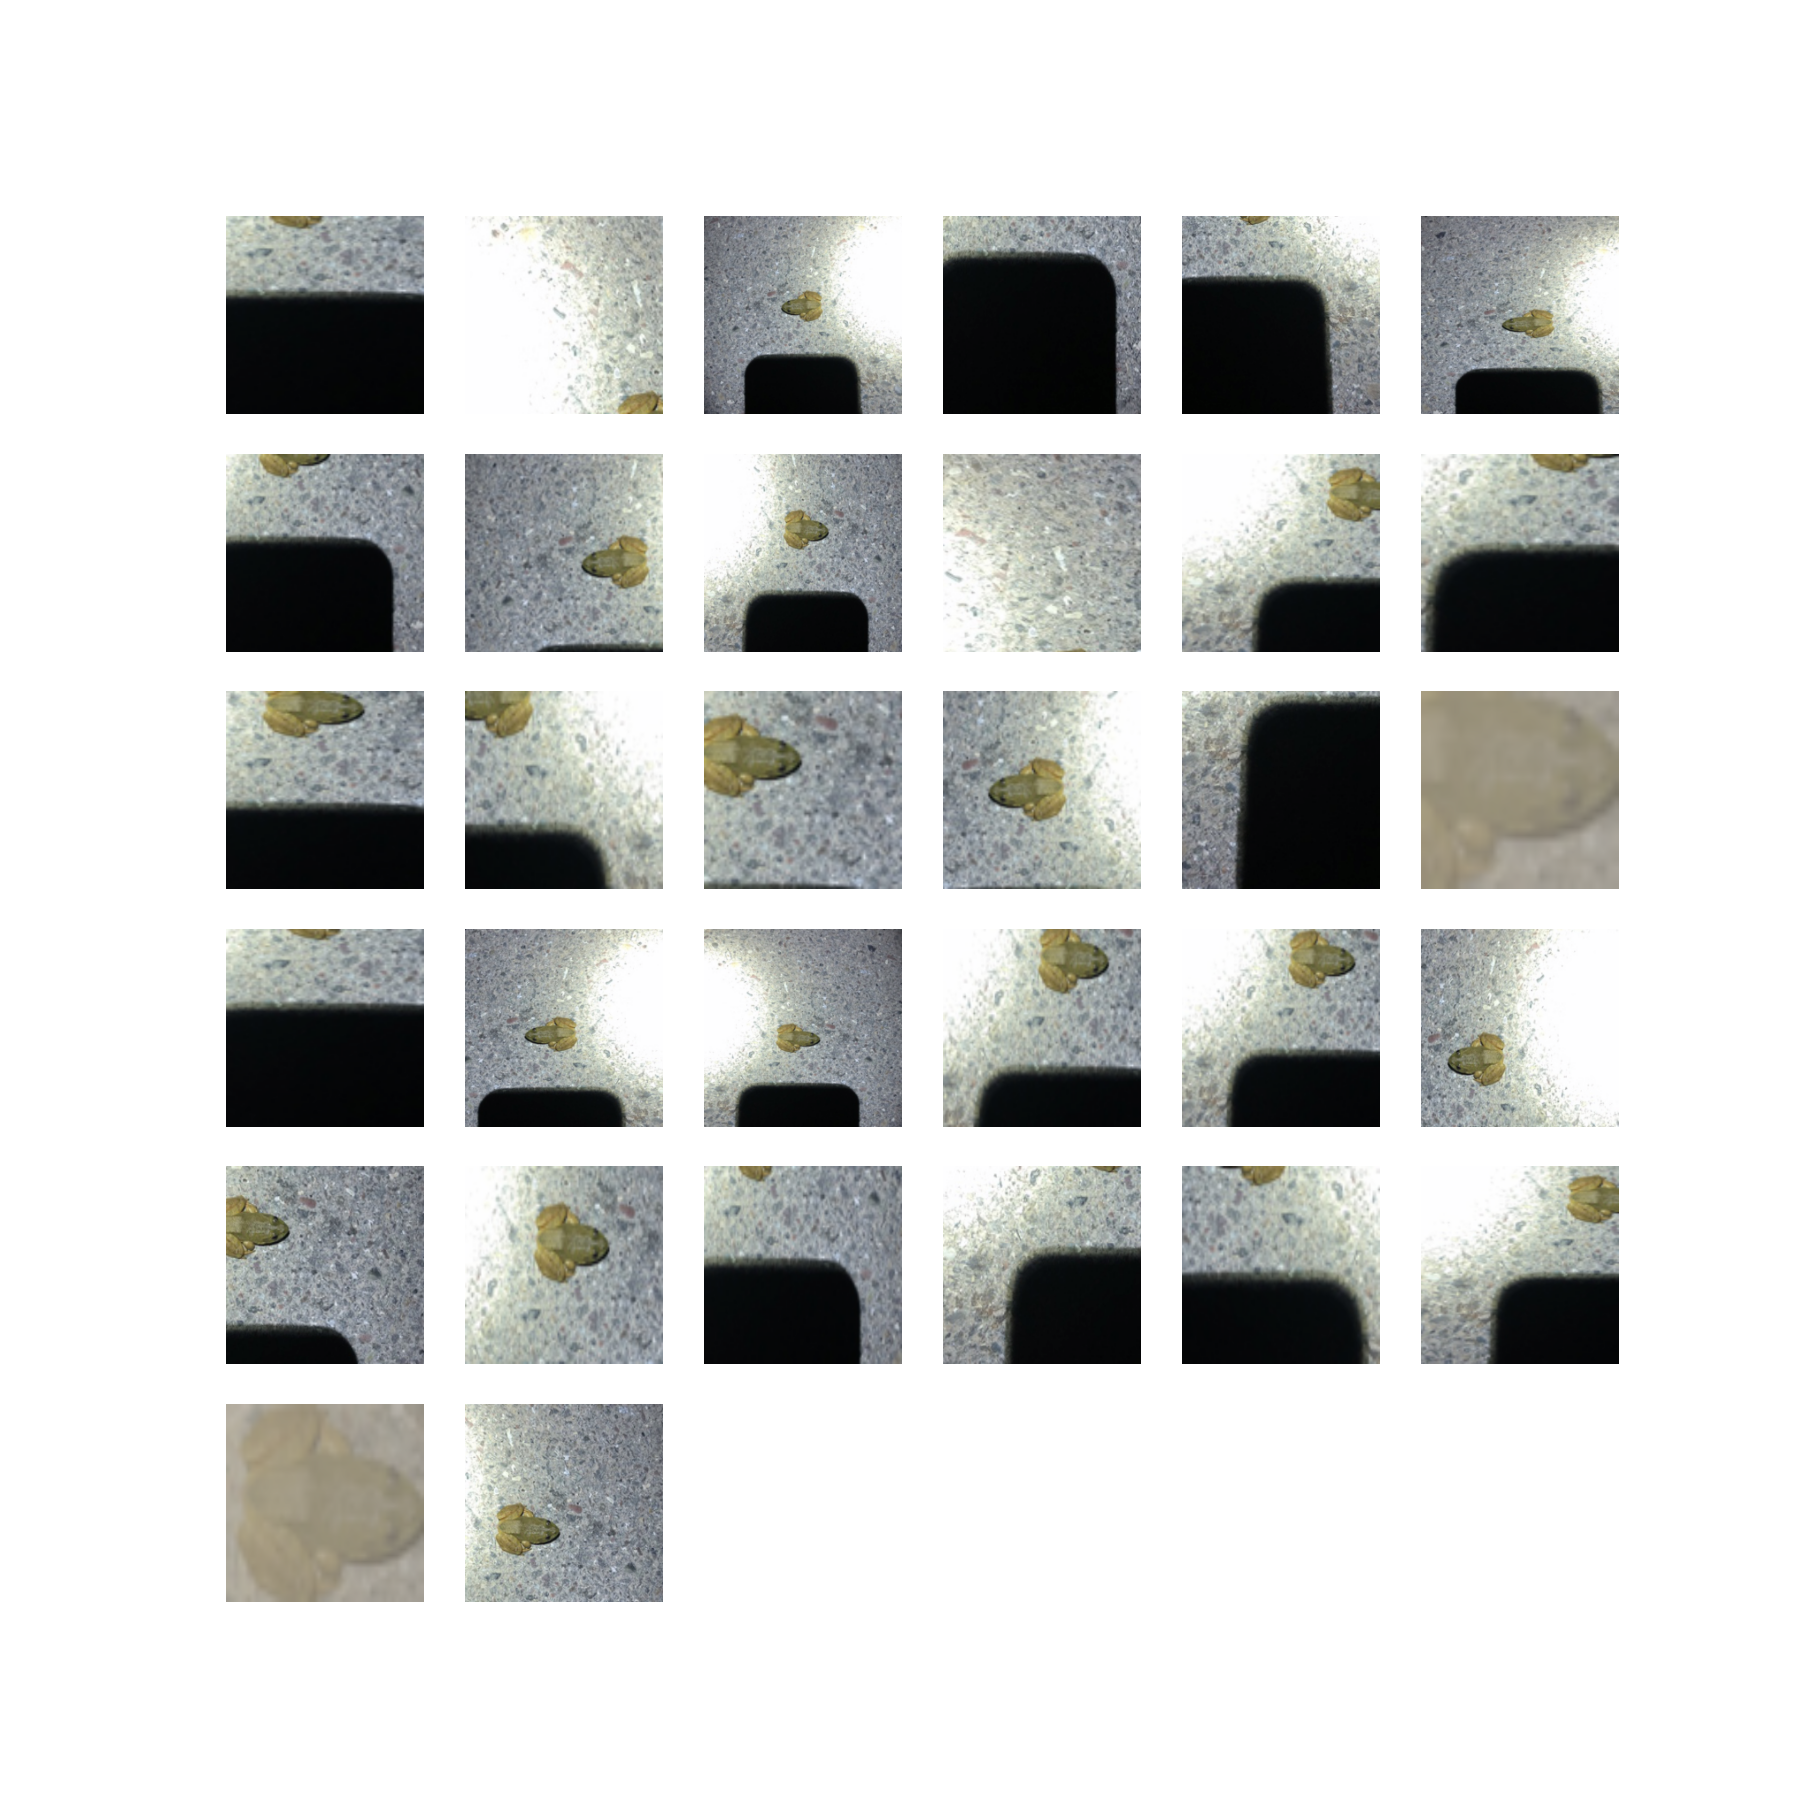

In this example we can see how the frog, which is the subject, is entirely contained in 24 augmentations in the DINO version, and only in 16 in the version without it.

In this way the model should be focused more on the subject.

--------------------------------------------

It can happen that the Dino model gives attention to the wrong subject in the photo, causing the generation of augmentations that do not contain the right subject.

Here an example where the augmentations generated give more attention to the stain on sweatshirt, rather than to the right subject, which is a fish.

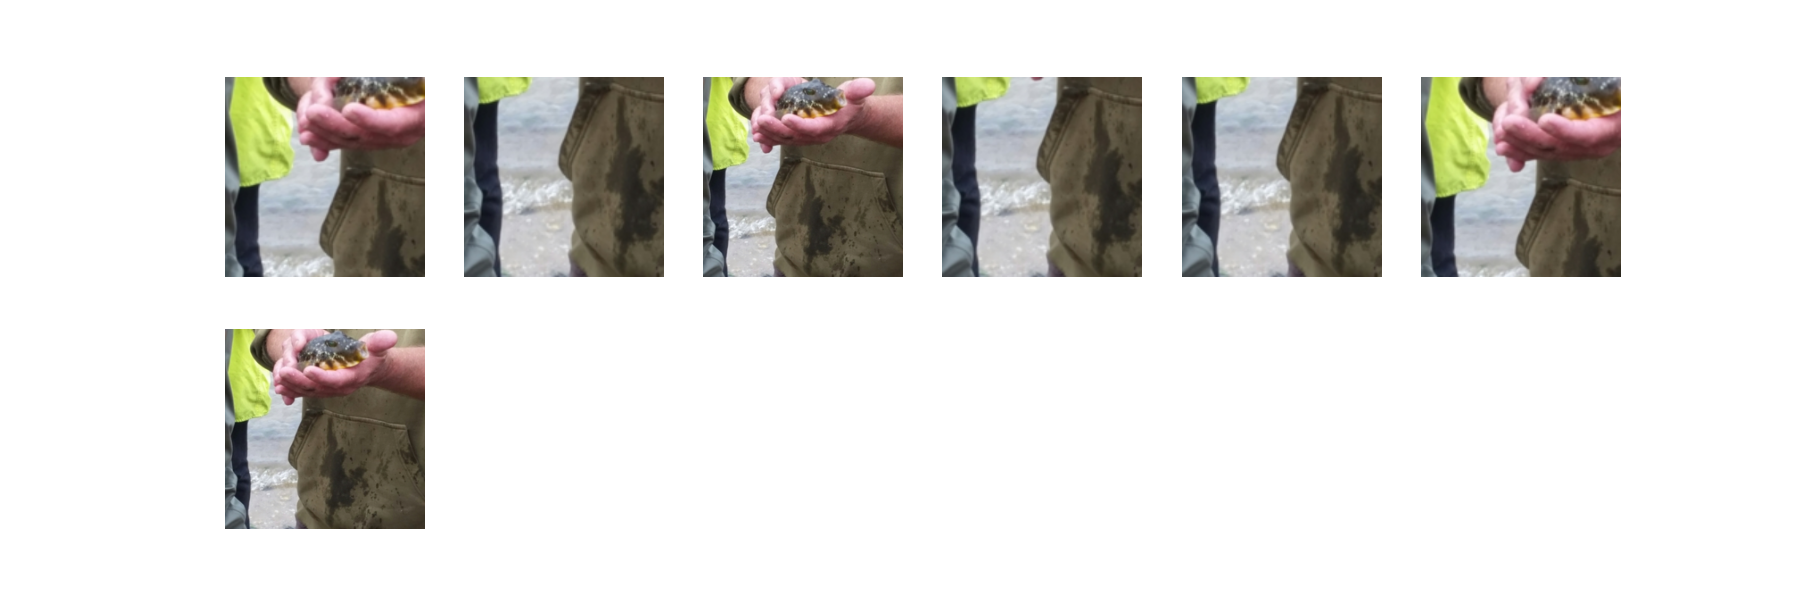

## 9.3 Results with both enanchements

A final trial is done combining the two improvements.

In [ ]:
set_random_seed(SEED)

classnames = imagenet_classes

normalize = transforms.Normalize(MEAN, STD)

base_transform = transforms.Compose([
    transforms.Resize(RESOLUTION, interpolation=BICUBIC),
    transforms.CenterCrop(RESOLUTION)])

preprocess = transforms.Compose([
              transforms.ToTensor(),
              normalize])

data_transform = AttentionGuidedAugmenter(base_transform, preprocess, model_dino, n_views=VIEWS, augmix=False)

batchsize = 1

classnames_all = imagenet_classes

classnames = [classnames_all[i] for i in imagenet_a_mask]

val_dataset = datasets.ImageFolder(DATA, data_transform)

print("number of test samples: {}".format(len(val_dataset)))

val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=batchsize, shuffle=True,
            num_workers=0, pin_memory=True)

number of test samples: 7500


In [ ]:
results = []

OUR_SELECTION = True
DINO = True

set_random_seed(SEED) #for making after the comparison between different results

model = OurCLIP(classnames=classnames, n_ctx=N_CTX, ctx_init=CTX_INIT)

if WEIGHTS is not None:
    print("Use pre-trained soft prompt (CoOp) as initialization")
    pretrained_ctx = torch.load(WEIGHTS)['state_dict']['ctx']
    assert pretrained_ctx.size()[0] == N_CTX
    with torch.no_grad():
        model.prompt_learner.ctx.copy_(pretrained_ctx)
        model.prompt_learner.ctx_init_state = pretrained_ctx

model_state = None

for name, param in model.named_parameters():
    if "prompt_learner" not in name:
        param.requires_grad_(False)

print("=> Model created: visual backbone {}".format(ARCH))

if not torch.cuda.is_available():
    print('using CPU, this will be slow')
else:
    assert GPU is not None
    torch.cuda.set_device(GPU)
    model = model.cuda(GPU)

# define optimizer
trainable_param = model.prompt_learner.parameters()
optimizer = torch.optim.AdamW(trainable_param, LR)
optim_state = deepcopy(optimizer.state_dict())

# setup automatic mixed-precision (Amp) loss scaling
scaler = torch.cuda.amp.GradScaler(init_scale=1000)

print('=> Using native Torch AMP. Training in mixed precision.')

cudnn.benchmark = True

model.reset_classnames(classnames)

results = test_time_adapt_eval(val_loader, model, optimizer, optim_state, scaler)

Random initialization: initializing a generic context
Initial context: "X X X X"
Number of context words (tokens): 4
Use pre-trained soft prompt (CoOp) as initialization
=> Model created: visual backbone RN50
=> Using native Torch AMP. Training in mixed precision.
Test: [   0/7500]	Time  0.927 ( 0.927)	Acc@1   0.00 (  0.00)	Acc@5 100.00 (100.00)
Test: [   1/7500]	Time  0.858 ( 0.892)	Acc@1   0.00 (  0.00)	Acc@5 100.00 (100.00)
Test: [   2/7500]	Time  0.853 ( 0.879)	Acc@1   0.00 (  0.00)	Acc@5   0.00 ( 66.67)
Test: [   3/7500]	Time  1.020 ( 0.914)	Acc@1   0.00 (  0.00)	Acc@5   0.00 ( 50.00)
Test: [   4/7500]	Time  1.029 ( 0.937)	Acc@1   0.00 (  0.00)	Acc@5   0.00 ( 40.00)
Test: [   5/7500]	Time  0.918 ( 0.934)	Acc@1   0.00 (  0.00)	Acc@5 100.00 ( 50.00)
Test: [   6/7500]	Time  0.847 ( 0.922)	Acc@1   0.00 (  0.00)	Acc@5 100.00 ( 57.14)
Test: [   7/7500]	Time  0.843 ( 0.912)	Acc@1   0.00 (  0.00)	Acc@5 100.00 ( 62.50)
Test: [   8/7500]	Time  0.845 ( 0.904)	Acc@1   0.00 (  0.00)	Acc@5 100.

## 9.4 Final conclusion


In the development of the TTA algorithm, starting from TPT as the baseline, we experimented with several methods, trying to recreate the results obtained by TPT and then proceeding to add methods to obtain other improvements.

The first step was to implement an adaptive confidence selection of the samples: the idea was not to choose every time the 10% of the images in the batch. The maximum number of possible selections is computed according to the local stationary points of the entropy curve.  Then the loss is calculated for each number between the 10% of the batch (in our case 6 images) and the upper bound found. The number of augmentations selected is the one which minimizes the loss.
In this way, our idea was to select the set of augmentations that best describe how the model understands a certain image.

With this step, the results obtained were different from those expected: from a theoretical point of view, this way of selecting is done in a more consistent way, and it would improve the baseline recreated by TPT. Despite that, it shows a small decrease in performances compared to the confidence selection proposed by TPT.
In any case, it is important to underline the fact that on some images, our method obtained better results.

Another improvement made was to use DINO model for the focal point estimation of the image, in order to produce in the next phase better augmentations.
This was done with the usage of attention heads and, from them, we could infer the main subject of the samples. To not cut it off from samples themselves, we dedicated to adjust the calculation of augmentations.

This method can improve the prediction of some cases and get worse on others. This could be explained by these facts:
- the DINO attention is wrong with respect to the label of the image,  
- the augmenting phase cuts off the context from the image. This could be fatal if the model has learned the discrimination also by some context features.

For example, we can have a photo of a butterfly on a flower. The augmentation will crop the butterfly, removing the flower. If the model has learned that the presence of the flower is discriminative, we obtain a wrong outcome.

Given the time needed to run the complete experiment, we decided to stop the computation of the cells in the notebook when they reached the twentieth image. The final conclusion and the displayed results are obtained from a complete run on the dataset.

We are aware that the two methods proposed do not improve the performance gained by TPT code. Despite that, we enhance some samples in the dataset.

A future task could involve the fine-tuning of our version, to maintain TPT's improvements and avoid missing the ones we made.


The results that Shu et al. achieved on imagenet-a are

| Model | Top 1 | Top 5 |
| --- | --- | --- |
| TPT + CoOp | 29.173 | 59.97 |



While ours are the following

| Model | Top 1 | Top 5 |
| --- | --- | --- |
| Our Selection + CoOp | 28.2 | 59.97 |
| DINO + CoOp | 28.3 | 60.03 |
| Our Selection + DINO + CoOp | 28.15 | 59.67 |